In [3]:
#!pip install -r ../requirements.txt
#!pip install pandas
#!pip install imbalanced-learn

In [7]:
import json
import os

# Chemin vers les checkpoints
checkpoint_dirs = ["checkpoint-4870", "checkpoint-5844"]
base_dir = "easy_xlmr_large_256"  # Ton répertoire de sortie

results = {}

for checkpoint in checkpoint_dirs:
    state_file = os.path.join(base_dir, checkpoint, "trainer_state.json")
    if os.path.exists(state_file):
        with open(state_file, "r") as f:
            state = json.load(f)
            # Chercher les métriques d'évaluation
            for log in state.get("log_history", []):
                if "eval_f1_pos" in log:
                    results[checkpoint] = log["eval_f1_pos"]
                    print(f"Checkpoint {checkpoint}: F1 positif = {log['eval_f1_pos']}")

if results:
    best_checkpoint = max(results, key=results.get)
    print(f"\nMeilleur checkpoint: {best_checkpoint} avec F1 positif = {results[best_checkpoint]}")
else:
    print("Aucune métrique d'évaluation trouvée dans les fichiers trainer_state.json")

Checkpoint checkpoint-4870: F1 positif = 0.6289120715350224
Checkpoint checkpoint-4870: F1 positif = 0.6740331491712708
Checkpoint checkpoint-4870: F1 positif = 0.6878980891719745
Checkpoint checkpoint-4870: F1 positif = 0.7181372549019608
Checkpoint checkpoint-4870: F1 positif = 0.7304347826086957
Checkpoint checkpoint-5844: F1 positif = 0.6289120715350224
Checkpoint checkpoint-5844: F1 positif = 0.6740331491712708
Checkpoint checkpoint-5844: F1 positif = 0.6878980891719745
Checkpoint checkpoint-5844: F1 positif = 0.7181372549019608
Checkpoint checkpoint-5844: F1 positif = 0.7304347826086957
Checkpoint checkpoint-5844: F1 positif = 0.7315270935960592

Meilleur checkpoint: checkpoint-5844 avec F1 positif = 0.7315270935960592


In [9]:
import json
import os

# Chemin vers les checkpoints
checkpoint_dirs = ["checkpoint-700", "checkpoint-2000", "checkpoint-2096"]
base_dir = "de_gbert_large_positive_f1"  # Ton répertoire de sortie

results = {}

for checkpoint in checkpoint_dirs:
    state_file = os.path.join(base_dir, checkpoint, "trainer_state.json")
    if os.path.exists(state_file):
        with open(state_file, "r") as f:
            state = json.load(f)
            # Chercher les métriques d'évaluation
            for log in state.get("log_history", []):
                if "eval_positive_f1" in log:
                    results[checkpoint] = log["eval_positive_f1"]
                    print(f"Checkpoint {checkpoint}: F1 positif = {log['eval_positive_f1']}")

if results:
    best_checkpoint = max(results, key=results.get)
    print(f"\nMeilleur checkpoint: {best_checkpoint} avec F1 positif = {results[best_checkpoint]}")
else:
    print("Aucune métrique d'évaluation trouvée dans les fichiers trainer_state.json")

Checkpoint checkpoint-700: F1 positif = 0.38666666666666666
Checkpoint checkpoint-700: F1 positif = 0.38823529411764707
Checkpoint checkpoint-700: F1 positif = 0.6756756756756757
Checkpoint checkpoint-700: F1 positif = 0.6329113924050633
Checkpoint checkpoint-700: F1 positif = 0.6170212765957447
Checkpoint checkpoint-700: F1 positif = 0.6567164179104478
Checkpoint checkpoint-700: F1 positif = 0.6774193548387097
Checkpoint checkpoint-2000: F1 positif = 0.38666666666666666
Checkpoint checkpoint-2000: F1 positif = 0.38823529411764707
Checkpoint checkpoint-2000: F1 positif = 0.6756756756756757
Checkpoint checkpoint-2000: F1 positif = 0.6329113924050633
Checkpoint checkpoint-2000: F1 positif = 0.6170212765957447
Checkpoint checkpoint-2000: F1 positif = 0.6567164179104478
Checkpoint checkpoint-2000: F1 positif = 0.6774193548387097
Checkpoint checkpoint-2000: F1 positif = 0.676470588235294
Checkpoint checkpoint-2000: F1 positif = 0.591549295774648
Checkpoint checkpoint-2000: F1 positif = 0.58

In [4]:
import os
import time
import random
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange 
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

## What is this notebook for?

This notebook showcases the loading of data, inference using our baseline model, evaluation of the predictions and dumping the predictions in the format required for upload on CodaLab.

# Data Analysis

## Examples

In [5]:
# Load the training data
train_data = pd.read_csv("data/train_data_SMM4H_2025_Task_1.csv")
dev_data = pd.read_csv("data/dev_data_SMM4H_2025_Task_1.csv")

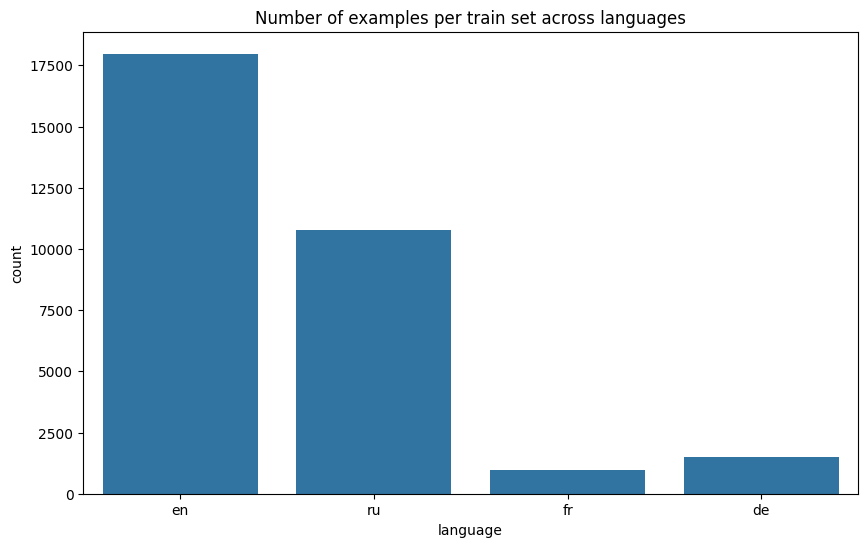

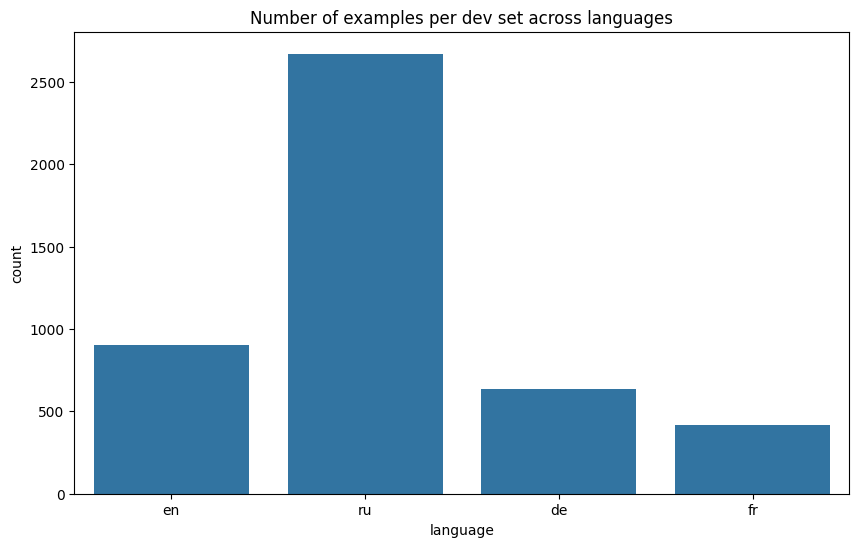

In [6]:
# plot the number of examples per train/dev set across languages

plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'])
plt.title("Number of examples per train set across languages")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'])
plt.title("Number of examples per dev set across languages")
plt.show()

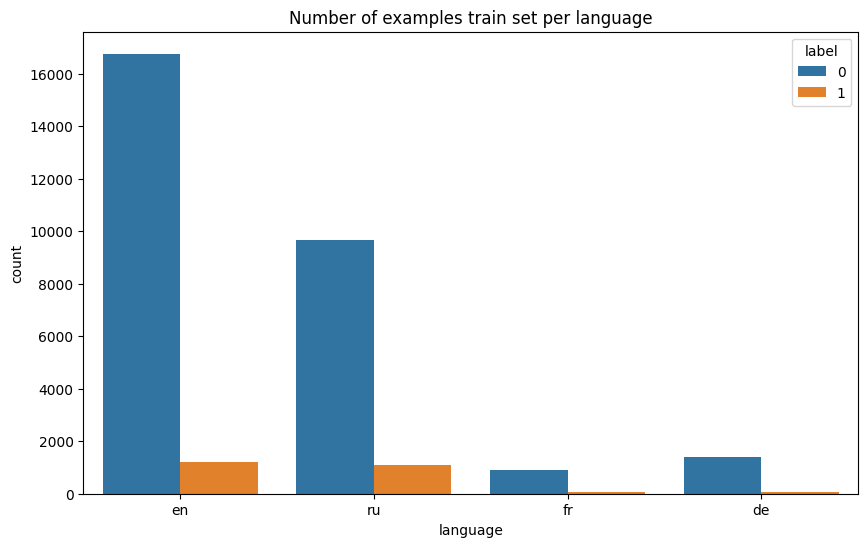

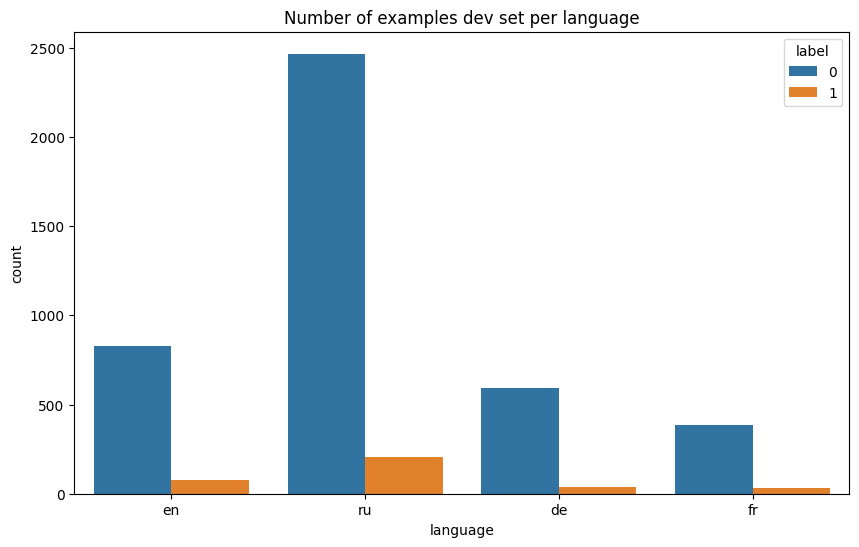

In [7]:
# plot the number of examples per train/dev per language
plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'], hue=train_data['label'])
plt.title("Number of examples train set per language")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'], hue=train_data['label'])
plt.title("Number of examples dev set per language")
plt.show()

In [8]:
# load the data as a pandas dataframe, show one random example of each language for each label
languages = train_data['language'].unique()
labels = train_data['label'].unique()
examples = []

for lang in languages:
    for label in labels:
        subset = train_data[(train_data['language'] == lang) & (train_data['label'] == label)]
        if not subset.empty:
            examples.append(subset.sample(1))

examples_df = pd.concat(examples)
print("Examples of each language and label:")
print(examples_df[['id', 'text', 'label', 'language']])

Examples of each language and label:
             id                                               text  label  \
21998  en_17543  struggling with effexor withdrawal. worse than...      1   
24807   en_6761                      Lunesta take me to dreamland!      0   
18513   ru_2744  но к концу приема, (т. е пили где то 20 дней е...      1   
1759   ru_12825  Вольтарен (300руб) и Диклофенак (40руб) Гастро...      0   
19842    fr_626  Salut <user> Avec les  suppositoires hormonaux...      1   
12079    fr_563  Je t'ai dit que ta PCR était sûre. Les sous-ty...      0   
24000   de_1211  Liebe Mädels, ich sende euch die besten Grüße....      1   
19982    de_760  Hallo <user>, jammern ist doch absolut ok. Tun...      0   

      language  
21998       en  
24807       en  
18513       ru  
1759        ru  
19842       fr  
12079       fr  
24000       de  
19982       de  


## Type Distribution

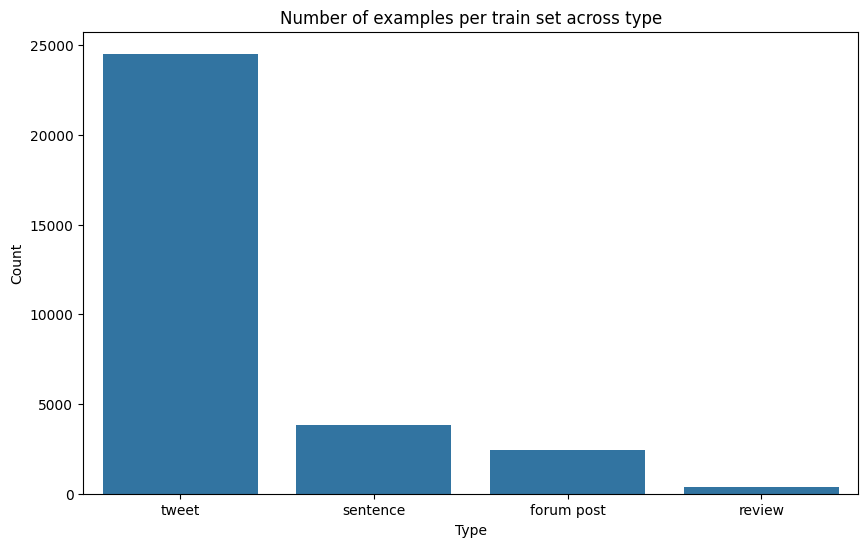

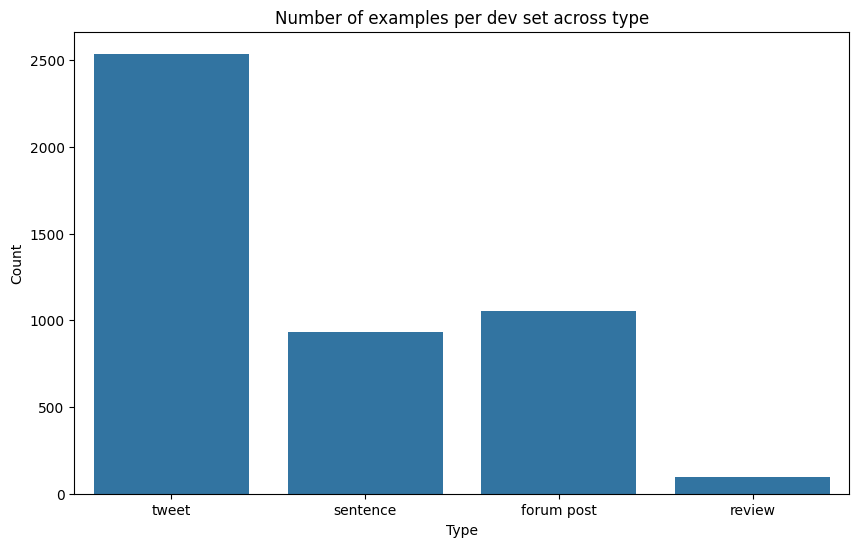

In [9]:
# Plot the number of examples per train/dev set across "type"

plt.figure(figsize=(10,6))
sns.countplot(x=train_data['type'])
plt.title("Number of examples per train set across type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['type'])
plt.title("Number of examples per dev set across type")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

## Label Distribution

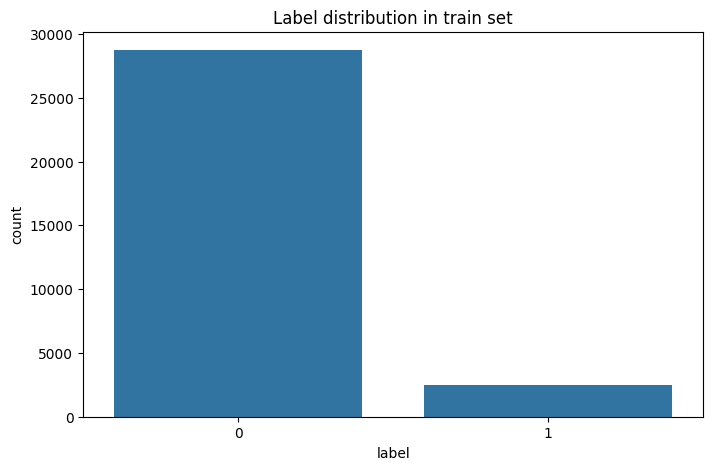

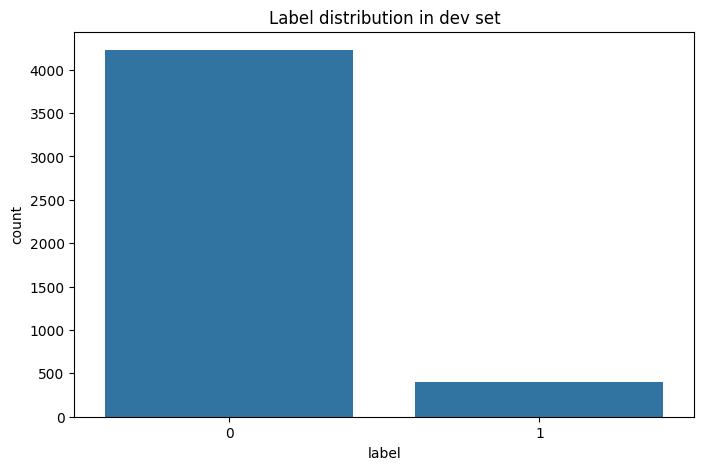

In [10]:
# plot the label distribution for the training and development sets (each one plot) across languages
plt.figure(figsize=(8,5))
sns.countplot(x=train_data['label'])
plt.title("Label distribution in train set")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x=dev_data['label'])
plt.title("Label distribution in dev set")
plt.show()

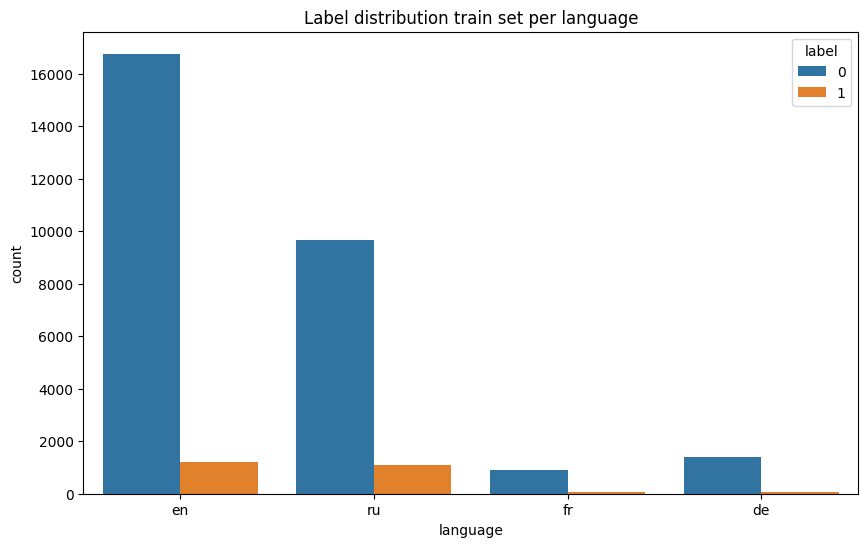

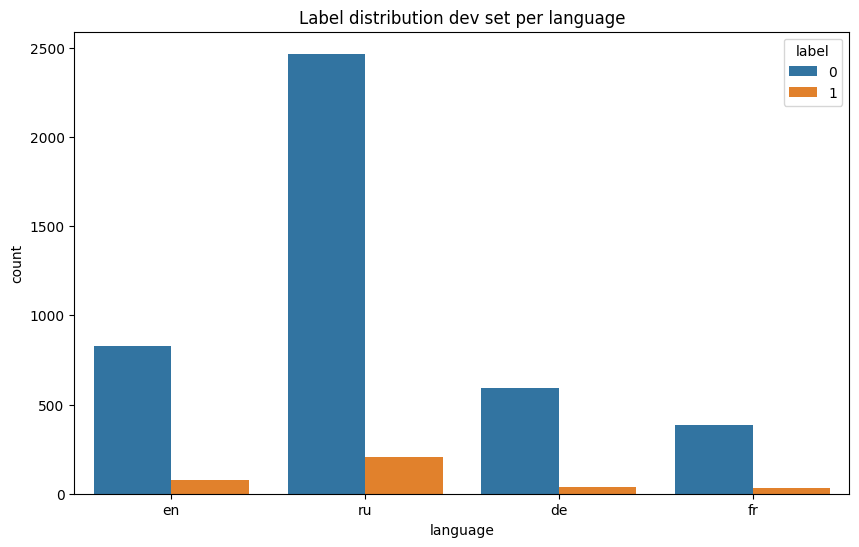

In [11]:
# plot the label distribution for the training and development sets per language 
plt.figure(figsize=(10,6))
sns.countplot(x=train_data['language'], hue=train_data['label'])
plt.title("Label distribution train set per language")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x=dev_data['language'], hue=train_data['label'])
plt.title("Label distribution dev set per language")
plt.show()

## Length of Messages 

In [12]:
def compute_text_length(df):
    df['text_length'] = df['text'].str.split().str.len().fillna(0).astype(int)
    return df

train_data = compute_text_length(train_data)
dev_data = compute_text_length(dev_data)

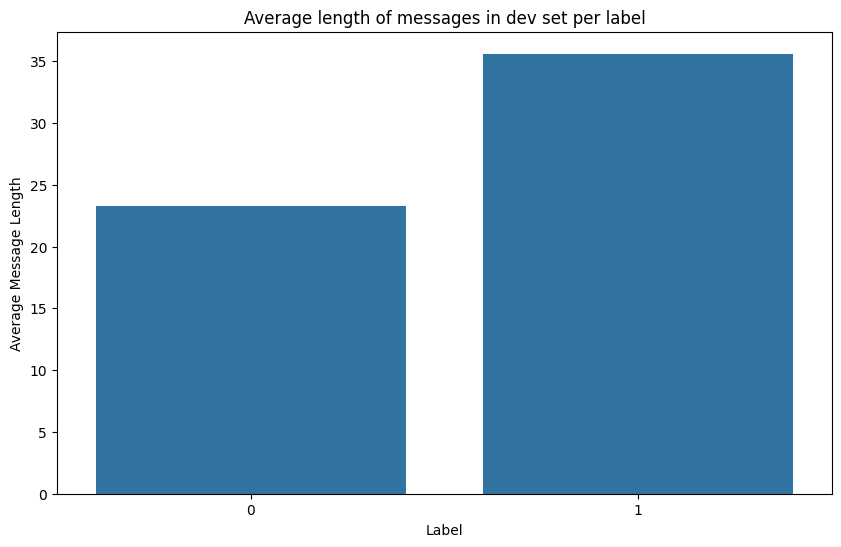

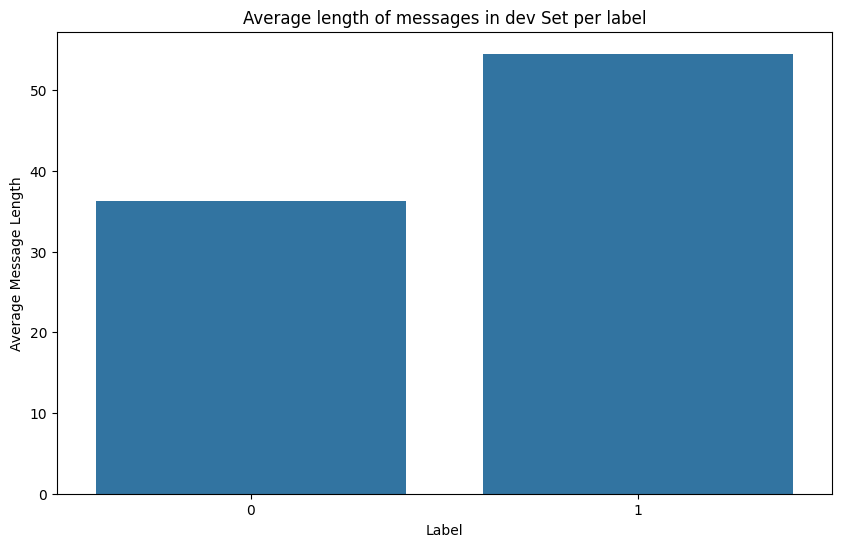

In [13]:
# plot the average length of messages across languages per train/dev set per label
plt.figure(figsize=(10,6))
sns.barplot(x=train_data['label'], y=train_data['text_length'], errorbar=None)
plt.title("Average length of messages in dev set per label")
plt.xlabel("Label")
plt.ylabel("Average Message Length")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=dev_data['label'], y=dev_data['text_length'], errorbar=None)
plt.title("Average length of messages in dev Set per label")
plt.xlabel("Label")
plt.ylabel("Average Message Length")
plt.show()


In [ ]:
# plot the average length of messages per language per train/dev set per label
plt.figure(figsize=(12,6))
sns.barplot(x=train_data['language'], y=train_data['text_length'], hue=train_data['label'], errorbar=None)
plt.title("Average length of messages per languages of train set per label")
plt.xlabel("Language")
plt.ylabel("Average Message Length")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=dev_data['language'], y=dev_data['text_length'], hue=train_data['label'], errorbar=None)
plt.title("Average length of messages per languages of dev set per label")
plt.xlabel("Language")
plt.ylabel("Average Message Length")
plt.show()

## Modèle de base tf-idf + random forest

Here, we show how to load a fine-tuned (Hugginface) model (our baseline) and perform inference on the development set. 

In [12]:
# tfidf_rf_imbalanced.py

import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from imblearn.over_sampling import RandomOverSampler

# ----- CONFIGURATION -----
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
RESULTS_DIR = "results"
CSV_FILENAME = "prediction_task1.csv"
ZIP_FILENAME = "submission_task1.zip"
DECISION_THRESHOLD = 0.3  # Adjust this threshold to favor positive predictions

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# ----- LOAD DATA -----
print("Loading training and development data...")
train_df = pd.read_csv(TRAIN_CSV)
dev_df = pd.read_csv(DEV_CSV)

# Ensure that text columns are strings
train_df["text"] = train_df["text"].astype(str)
dev_df["text"] = dev_df["text"].astype(str)

# Extract features and labels
X_train = train_df["text"]
y_train = train_df["label"]
X_dev = dev_df["text"]
y_dev = dev_df["label"]

print(f"Training data: {len(train_df)} samples")
print(f"Development data: {len(dev_df)} samples")

# ----- TF-IDF VECTORIZATION -----
print("Vectorizing text using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
print("TF-IDF vectorization complete.")

# ----- OVERSAMPLING -----
print("Applying RandomOverSampler to balance classes...")
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)
print("Oversampling complete. New training samples:", X_train_res.shape[0])

# ----- TRAIN RANDOM FOREST CLASSIFIER -----
print("Training Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
print("Training complete.")

# ----- EVALUATE ON DEVELOPMENT SET -----
print("Evaluating model on development data...")
y_proba = rf.predict_proba(X_dev_tfidf)
y_pred_adjusted = np.where(y_proba[:, 1] > DECISION_THRESHOLD, 1, 0)

print("\nClassification Report:")
print(classification_report(y_dev, y_pred_adjusted, digits=4, zero_division=0))
print("Accuracy:", accuracy_score(y_dev, y_pred_adjusted))

# ----- SAVE PREDICTIONS -----
csv_path = os.path.join(RESULTS_DIR, CSV_FILENAME)
dev_df["predicted_label"] = y_pred_adjusted
dev_df[["id", "predicted_label"]].to_csv(csv_path, index=False)
print(f"Predictions saved to {csv_path}")

# ----- ZIP THE CSV FILE -----
zip_path = os.path.join(RESULTS_DIR, ZIP_FILENAME)
with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path, arcname=CSV_FILENAME)

print(f"{CSV_FILENAME} has been zipped into {zip_path}")


from sklearn.metrics import precision_score, recall_score, f1_score

# Get the language prefix from the ID (e.g., 'de', 'en', etc.)
dev_df["lang"] = dev_df["id"].apply(lambda x: x.split("_")[0])

languages = dev_df["lang"].unique()
lang_metrics = []

print("\n----- Per-Language Evaluation -----")
for lang in sorted(languages):
    lang_mask = dev_df["lang"] == lang
    y_true_lang = dev_df.loc[lang_mask, "label"]
    y_pred_lang = dev_df.loc[lang_mask, "predicted_label"]

    precision = precision_score(y_true_lang, y_pred_lang, zero_division=0)
    recall = recall_score(y_true_lang, y_pred_lang, zero_division=0)
    f1 = f1_score(y_true_lang, y_pred_lang, zero_division=0)
    accuracy = accuracy_score(y_true_lang, y_pred_lang)

    lang_metrics.append(f1)  # for macro F1 later

    print(f"Precision-{lang}: {precision:.4f}")
    print(f"Recall-{lang}: {recall:.4f}")
    print(f"F1-{lang}: {f1:.4f}")
    print(f"Accuracy-{lang}: {accuracy:.4f}\n")

# Global F1 and Accuracy
overall_f1 = f1_score(y_dev, y_pred_adjusted, zero_division=0)
macro_f1 = np.mean(lang_metrics)
overall_accuracy = accuracy_score(y_dev, y_pred_adjusted)

print("F1-score across all languages:", f"{overall_f1:.4f}")
print("Macro F1-score across all languages:", f"{macro_f1:.4f}")
print("Overall Accuracy:", f"{overall_accuracy:.4f}")


Loading training and development data...
Training data: 31187 samples
Development data: 4625 samples
Vectorizing text using TF-IDF...
TF-IDF vectorization complete.
Applying RandomOverSampler to balance classes...
Oversampling complete. New training samples: 57472
Training Random Forest classifier...
Training complete.
Evaluating model on development data...

Classification Report:
              precision    recall  f1-score   support

           0     0.9524    0.9411    0.9467      4227
           1     0.4442    0.5000    0.4704       398

    accuracy                         0.9031      4625
   macro avg     0.6983    0.7205    0.7086      4625
weighted avg     0.9086    0.9031    0.9057      4625

Accuracy: 0.9031351351351351
Predictions saved to results\prediction_task1.csv
prediction_task1.csv has been zipped into results\submission_task1.zip

----- Per-Language Evaluation -----
Precision-de: 0.8667
Recall-de: 0.3714
F1-de: 0.5200
Accuracy-de: 0.9621

Precision-en: 0.6000
Recall

## BASE TF-IDF + RANDOM FOREST mais avec affichage résultats Sonnet 3.7

In [8]:
# tfidf_rf_imbalanced.py

import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score, # Added
    recall_score,    # Added
    confusion_matrix,
    # ConfusionMatrixDisplay # Not strictly needed for metric calculation
)
# import matplotlib.pyplot as plt # Not strictly needed for metric calculation
# import seaborn as sns # Not strictly needed for metric calculation
import zipfile
from imblearn.over_sampling import RandomOverSampler

# ----- CONFIGURATION -----
TRAIN_CSV = "data/augmented_gemini_train_data_varied_length.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
RESULTS_DIR = "results"
CSV_FILENAME = "prediction_task1.csv"
ZIP_FILENAME = "submission_task1.zip"
DECISION_THRESHOLD = 0.3  # Adjust this threshold to favor positive predictions

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# ----- LOAD DATA -----
print("Loading training and development data...")
# Make sure the CSV files exist at these paths or adjust the paths
try:
    train_df = pd.read_csv(TRAIN_CSV)
    dev_df = pd.read_csv(DEV_CSV)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the CSV files are in the correct 'data/' directory.")
    exit()


# Ensure that text columns are strings and handle potential NaN values
train_df["text"] = train_df["text"].fillna("").astype(str)
dev_df["text"] = dev_df["text"].fillna("").astype(str)

# Extract features and labels
X_train = train_df["text"]
y_train = train_df["label"]
X_dev = dev_df["text"]
y_dev = dev_df["label"]
dev_languages = dev_df['language'] # Keep track of languages in dev set

print(f"Training data: {len(train_df)} samples")
print(f"Development data: {len(dev_df)} samples")
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in development data:")
print(y_dev.value_counts(normalize=True))


# ----- TF-IDF VECTORIZATION -----
print("\nVectorizing text using TF-IDF...")
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
print("TF-IDF vectorization complete.")

# ----- OVERSAMPLING -----
print("\nApplying RandomOverSampler to balance training classes...")
ros = RandomOverSampler(random_state=42)
# Check if there are positive samples before resampling
if 1 in y_train.value_counts():
    X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)
    print(f"Oversampling complete. New training samples: {X_train_res.shape[0]}")
    print("Class distribution after oversampling:")
    print(pd.Series(y_train_res).value_counts(normalize=True))
else:
    print("Warning: No positive samples found in the training data for oversampling.")
    X_train_res, y_train_res = X_train_tfidf, y_train # Use original data if no positive samples


# ----- TRAIN RANDOM FOREST CLASSIFIER -----
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced', # Still useful even with oversampling
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
print("Training complete.")

# ----- PREDICT ON DEVELOPMENT SET -----
print("\nPredicting probabilities on development data...")
y_proba = rf.predict_proba(X_dev_tfidf)
# Apply custom threshold for final predictions (class 1 if proba > threshold)
y_pred_adjusted = np.where(y_proba[:, 1] > DECISION_THRESHOLD, 1, 0)
print(f"Predictions made using threshold {DECISION_THRESHOLD}.")

# Attach predictions to the dev dataframe for easier per-language evaluation
dev_df["predicted_label"] = y_pred_adjusted

# ----- DETAILED EVALUATION (Like Challenge Baseline) -----
print("\n----- Detailed Evaluation on Development Set -----")

languages = dev_df['language'].unique()
per_language_metrics = {}
language_f1_scores = []
all_true_labels = []
all_pred_labels = []

for lang in sorted(languages): # Sort for consistent output order
    lang_mask = dev_df['language'] == lang
    y_true_lang = dev_df.loc[lang_mask, 'label']
    y_pred_lang = dev_df.loc[lang_mask, 'predicted_label']

    # Store labels for overall calculation later
    all_true_labels.extend(y_true_lang.tolist())
    all_pred_labels.extend(y_pred_lang.tolist())

    # Calculate metrics for the current language (positive class = 1)
    precision = precision_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    recall = recall_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    f1 = f1_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true_lang, y_pred_lang)

    per_language_metrics[lang] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }
    language_f1_scores.append(f1) # Store F1 for macro calculation

    print(f"\nMetrics for language: {lang.upper()}")
    print(f"  Precision-{lang}: {precision:.4f}")
    print(f"  Recall-{lang}:    {recall:.4f}")
    print(f"  F1-{lang}:        {f1:.4f}")
    print(f"  Accuracy-{lang}:  {accuracy:.4f}")
    # Optional: Show confusion matrix per language
    # cm_lang = confusion_matrix(y_true_lang, y_pred_lang, labels=[0, 1])
    # print(f"  Confusion Matrix-{lang}:\n{cm_lang}")


# --- Calculate Overall Metrics ---

# Overall F1-score (based on total TP, FP, FN across all languages)
# Use the collected all_true_labels and all_pred_labels which cover the whole dev set
cm_overall = confusion_matrix(all_true_labels, all_pred_labels, labels=[0, 1])
tn, fp, fn, tp = cm_overall.ravel()

overall_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
overall_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

# Macro F1-score (average of per-language F1 scores)
macro_f1 = np.mean(language_f1_scores)

# Overall Accuracy
overall_accuracy = accuracy_score(all_true_labels, all_pred_labels)

print("\n----- Overall Evaluation Summary -----")
print(f"F1-score across all languages (Positive Class): {overall_f1:.4f}  <-- Primary Metric")
print(f"Macro F1-score across all languages:            {macro_f1:.4f}")
print(f"Overall Accuracy across all languages:          {overall_accuracy:.4f}")

print("\nOverall Confusion Matrix (All Languages):")
print(f"[[TN={tn}  FP={fp}]")
print(f" [FN={fn}  TP={tp}]]")

# ----- (Optional) Original Classification Report for comparison -----
# print("\nOriginal Classification Report (All languages combined, sklearn default):")
# print(classification_report(y_dev, y_pred_adjusted, digits=4, zero_division=0))


# ----- SAVE PREDICTIONS -----
#print("\nSaving predictions for the development set...")
#csv_path = os.path.join(RESULTS_DIR, CSV_FILENAME)
# Ensure we only save 'id' and 'predicted_label' columns as required
#dev_df[["id", "predicted_label"]].to_csv(csv_path, index=False)
#print(f"Predictions saved to {csv_path}")

# ----- ZIP THE CSV FILE -----
#zip_path = os.path.join(RESULTS_DIR, ZIP_FILENAME)
#with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    #zf.write(csv_path, arcname=CSV_FILENAME)

#print(f"{CSV_FILENAME} has been zipped into {zip_path}")
#print("----- Script Finished -----")

Loading training and development data...
Training data: 31302 samples
Development data: 4625 samples
Class distribution in training data:
label
0    0.918024
1    0.081976
Name: proportion, dtype: float64

Class distribution in development data:
label
0    0.913946
1    0.086054
Name: proportion, dtype: float64

Vectorizing text using TF-IDF...
TF-IDF vectorization complete.

Applying RandomOverSampler to balance training classes...
Oversampling complete. New training samples: 57472
Class distribution after oversampling:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Training Random Forest classifier...
Training complete.

Predicting probabilities on development data...
Predictions made using threshold 0.3.

----- Detailed Evaluation on Development Set -----

Metrics for language: DE
  Precision-de: 0.5333
  Recall-de:    0.4571
  F1-de:        0.4923
  Accuracy-de:  0.9479

Metrics for language: EN
  Precision-en: 0.5714
  Recall-en:    0.4590
  F1-en:        0.5091
  Accur

## Deutsch TF IDF + RANDOM FOREST

In [ ]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import pandas as pd
import torch
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import os

# --- Chargement et filtrage des données allemandes ---
df_train = pd.read_csv("data/augmented_gemini_train_data_varied_length.csv")
df_dev = pd.read_csv("data/dev_data_SMM4H_2025_Task_1.csv")

# Garder seulement les textes allemands
df_train_de = df_train[df_train["language"] == "de"].dropna(subset=["text"])
df_dev_de = df_dev[df_dev["language"] == "de"].dropna(subset=["text"])

# --- Affichage de la distribution des classes ---
positive_train = df_train_de[df_train_de.label == 1].shape[0]
total_train = df_train_de.shape[0]
print(f"Distribution des classes dans les données d'entraînement originales:")
print(f"Classe positive: {positive_train} ({positive_train/total_train*100:.2f}%)")
print(f"Classe négative: {total_train - positive_train} ({(total_train - positive_train)/total_train*100:.2f}%)")

# --- Rééquilibrage des classes ---
# Séparation des deux classes
df_majority = df_train_de[df_train_de.label == 0]
df_minority = df_train_de[df_train_de.label == 1]

# Suréchantillonnage de la classe minoritaire
# Utiliser un ratio plus élevé pour favoriser la détection des positifs
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority)//2,  # Ratio 1:2 pour donner plus d'importance à la classe positive
    random_state=42
)

# Combiner les datasets
df_train_de_balanced = pd.concat([df_majority, df_minority_upsampled])
positive_balanced = df_train_de_balanced[df_train_de_balanced.label == 1].shape[0]
total_balanced = df_train_de_balanced.shape[0]

print(f"\nDistribution des classes après rééquilibrage:")
print(f"Classe positive: {positive_balanced} ({positive_balanced/total_balanced*100:.2f}%)")
print(f"Classe négative: {total_balanced - positive_balanced} ({(total_balanced - positive_balanced)/total_balanced*100:.2f}%)")

# Mélanger les données
df_train_de_balanced = df_train_de_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Convertir en dataset Hugging Face
train_dataset = Dataset.from_pandas(df_train_de_balanced)
eval_dataset = Dataset.from_pandas(df_dev_de.reset_index(drop=True))

# --- Tokenizer ---
model_name = "deepset/gbert-large"  # Utiliser le modèle LARGE pour l'allemand qui a plus de capacité
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["text"], 
        truncation=True, 
        padding="max_length", 
        max_length=512
    )

# Tokenisation des datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Renommer la colonne label en labels pour Trainer
train_dataset = train_dataset.rename_column("label", "labels")
eval_dataset = eval_dataset.rename_column("label", "labels")

# Définir le format pour PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# --- Calcul des poids pour mettre l'accent sur la classe positive ---
# Plus le poids est élevé pour la classe positive, plus le modèle va privilégier la détection des ADEs
class_weights = torch.tensor([0.3, 0.7], dtype=torch.float)  # Favoriser fortement la classe positive (ADEs)

# --- Custom Trainer qui se concentre sur la classe positive ---
class PositiveF1Trainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Weighted CrossEntropyLoss pour favoriser la détection des positifs
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights.to(model.device)
        )
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# --- Fonction de métrique qui se focalise spécifiquement sur le F1 de la classe positive ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculer TP, FP, FN en se concentrant spécifiquement sur la classe positive (1)
    cm = confusion_matrix(labels, preds)
    
    # Extraire la matrice de confusion
    if cm.shape[0] > 1:  # S'assurer que les deux classes sont présentes
        tn, fp, fn, tp = cm.ravel()
    else:  # Si une seule classe est prédite
        if preds[0] == 1:  # Si c'est la classe positive
            tp = np.sum(labels == 1)
            fp = np.sum(labels == 0)
            fn = 0
            tn = 0
        else:  # Si c'est la classe négative
            tp = 0
            fp = 0
            fn = np.sum(labels == 1)
            tn = np.sum(labels == 0)
    
    # Calculer precision et recall pour la classe positive uniquement
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculer le F1 score pour la classe positive uniquement
    f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
    
    return {
        "positive_precision": precision,
        "positive_recall": recall,
        "positive_f1": f1,
        "TP": tp,
        "FP": fp,
        "FN": fn
    }

# --- Model ---
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    problem_type="single_label_classification"
)

# --- Arguments d'entraînement ---
output_dir = "de_gbert_large_positive_f1"
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    num_train_epochs=8,
    per_device_train_batch_size=4,  # Réduit pour gbert-large
    per_device_eval_batch_size=8,
    learning_rate=3e-5,  # Learning rate légèrement ajusté
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="positive_f1",  # Focus sur le F1 de la classe positive
    greater_is_better=True,
    fp16=True,  # Utiliser la précision mixte pour accélérer l'entraînement
    gradient_accumulation_steps=2,  # Pour augmenter la taille effective du batch
    warmup_ratio=0.1,
    save_total_limit=3,  # Garder les 3 meilleurs checkpoints
)

# --- Trainer ---
trainer = PositiveF1Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# --- Train ---
trainer.train()
print("\nÉvaluation finale:")
final_results = trainer.evaluate()
print(final_results)

# --- Recherche du seuil optimal pour maximiser le F1 de la classe positive ---
print("\nRecherche du seuil optimal pour maximiser le F1 de la classe positive...")
predictions = trainer.predict(eval_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:,1].numpy()
labels = predictions.label_ids

best_threshold = 0.5
best_f1 = 0

# Tester différents seuils pour maximiser le F1 spécifiquement pour la classe positive
thresholds = np.arange(0.01, 0.99, 0.01)
results = []

for threshold in thresholds:
    preds = (probs >= threshold).astype(int)
    
    # Calcul de TP, FP, FN pour la classe positive
    tp = np.sum((preds == 1) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    fn = np.sum((preds == 0) & (labels == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Trouver les 5 meilleurs seuils
results_df = pd.DataFrame(results)
top_thresholds = results_df.sort_values('f1', ascending=False).head(5)

print(f"\nMeilleur seuil trouvé: {best_threshold:.2f}, F1 score pour la classe positive: {best_f1:.4f}")
print("\nTop 5 des meilleurs seuils:")
for _, row in top_thresholds.iterrows():
    print(f"Seuil: {row['threshold']:.2f}, Precision: {row['precision']:.4f}, Recall: {row['recall']:.4f}, F1: {row['f1']:.4f}")

# --- Sauvegarder le modèle et le seuil optimal ---
trainer.save_model(output_dir)
with open(os.path.join(output_dir, "optimal_threshold.txt"), "w") as f:
    f.write(str(best_threshold))

print(f"\nModèle et seuil optimal sauvegardés dans {output_dir}")

# --- Fonction de prédiction avec le seuil optimal ---
def predict_with_optimal_threshold(text, model, tokenizer, threshold):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    prediction = 1 if probs[0][1].item() >= threshold else 0
    
    # Appliquer le seuil optimal
    return {
        'prediction': prediction,
        'confidence': probs[0][1].item(),
        'is_ade': prediction == 1
    }

# --- Code pour faire des prédictions sur le test set ---
def predict_test_set(test_file, model, tokenizer, threshold):
    df_test = pd.read_csv(test_file)
    df_test_de = df_test[df_test["language"] == "de"].dropna(subset=["text"])
    
    results = []
    
    for idx, row in df_test_de.iterrows():
        pred = predict_with_optimal_threshold(row["text"], model, tokenizer, threshold)
        results.append({
            'id': row.get('id', idx),
            'text': row['text'],
            'prediction': pred['prediction'],
            'confidence': pred['confidence']
        })
    
    results_df = pd.DataFrame(results)
    return results_df

print("\nExemple d'utilisation de la fonction de prédiction:")
sample_text = "Nach der Einnahme dieses Medikaments hatte ich drei Tage lang starke Kopfschmerzen."
result = predict_with_optimal_threshold(sample_text, model, tokenizer, best_threshold)
print(f"Texte: '{sample_text}'")
print(f"Prédiction: {result['prediction']} ({'contient un ADE' if result['is_ade'] else 'ne contient pas d\'ADE'})")
print(f"Confiance: {result['confidence']:.4f}")

Distribution des classes dans les données d'entraînement originales:
Classe positive: 153 (9.86%)
Classe négative: 1399 (90.14%)

Distribution des classes après rééquilibrage:
Classe positive: 699 (33.32%)
Classe négative: 1399 (66.68%)


Map:   0%|          | 0/2098 [00:00<?, ? examples/s]

Map:   0%|          | 0/634 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Olivier\AppData\Local\Temp\ipykernel_13456\2030998234.py:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PositiveF1Trainer.__init__`. Use `processing_class` instead.
  trainer = PositiveF1Trainer(


Step,Training Loss,Validation Loss,Positive Precision,Positive Recall,Positive F1,Tp,Fp,Fn
100,0.401900,0.332004,0.252174,0.828571,0.386667,29,86,6
200,0.324900,0.462635,0.244444,0.942857,0.388235,33,102,2
300,0.228500,0.213296,0.641026,0.714286,0.675676,25,14,10
400,0.162100,0.242121,0.568182,0.714286,0.632911,25,19,10
500,0.046100,0.348172,0.491525,0.828571,0.617021,29,30,6
600,0.015400,0.321664,0.687500,0.628571,0.656716,22,10,13
700,0.009300,0.304686,0.777778,0.600000,0.677419,21,6,14
800,0.037500,0.308198,0.696970,0.657143,0.676471,23,10,12
900,0.002000,0.422571,0.583333,0.600000,0.591549,21,15,14
1000,0.010600,0.512111,0.739130,0.485714,0.586207,17,6,18



Évaluation finale:


{'eval_loss': 0.3046858608722687, 'eval_positive_precision': 0.7777777777777778, 'eval_positive_recall': 0.6, 'eval_positive_f1': 0.6774193548387097, 'eval_TP': 21, 'eval_FP': 6, 'eval_FN': 14, 'eval_runtime': 2.8653, 'eval_samples_per_second': 221.269, 'eval_steps_per_second': 13.96, 'epoch': 7.972354623450905}

Recherche du seuil optimal pour maximiser le F1 de la classe positive...

Meilleur seuil trouvé: 0.14, F1 score pour la classe positive: 0.7385

Top 5 des meilleurs seuils:
Seuil: 0.27, Precision: 0.8000, Recall: 0.6857, F1: 0.7385
Seuil: 0.15, Precision: 0.8000, Recall: 0.6857, F1: 0.7385
Seuil: 0.26, Precision: 0.8000, Recall: 0.6857, F1: 0.7385
Seuil: 0.25, Precision: 0.8000, Recall: 0.6857, F1: 0.7385
Seuil: 0.24, Precision: 0.8000, Recall: 0.6857, F1: 0.7385

Modèle et seuil optimal sauvegardés dans de_gbert_large_positive_f1


## Sentence embeddings (E5 multilingual) + Random Forest

In [8]:
# e5_rf_imbalanced.py

import os
import pandas as pd
import numpy as np
import torch # PyTorch est nécessaire pour sentence-transformers
from sentence_transformers import SentenceTransformer # Pour E5
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import zipfile
from imblearn.over_sampling import RandomOverSampler
import time
import wandb # <-- Importer wandb

# ----- CONFIGURATION -----
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
E5_MODEL_NAME = 'intfloat/multilingual-e5-large' # Modèle E5 multilingue
RESULTS_DIR = "results_e5_rf" # Nouveau répertoire
CSV_FILENAME = "prediction_task1_e5_rf.csv"
ZIP_FILENAME = "submission_task1_e5_rf.zip"
DECISION_THRESHOLD = 0.3  # Gardé pour l'instant, mais pourrait nécessiter un ajustement

# --- RandomForest Parameters (Might need tuning for embeddings) ---
RF_N_ESTIMATORS = 150 # Un peu plus d'arbres peut être utile
RF_MAX_DEPTH = None   # Laisser les arbres grandir
RF_MIN_SAMPLES_SPLIT = 5
RF_MIN_SAMPLES_LEAF = 2
RANDOM_STATE = 42 # Pour la reproductibilité

# Ensure results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# ----- WANDB Initialization -----
# Initialise le suivi avec Weights & Biases
# Remplace "your-project-name" par le nom de ton projet wandb (ex: "smm4h-task1")
wandb.init(
    project="smm4h-task1-e5", # Adapte le nom du projet si besoin
    name="E5 large multi",   # Le nom demandé pour cette exécution
    config={                # Enregistre les hyperparamètres et la configuration
        "train_csv": TRAIN_CSV,
        "dev_csv": DEV_CSV,
        "e5_model_name": E5_MODEL_NAME,
        "rf_n_estimators": RF_N_ESTIMATORS,
        "rf_max_depth": RF_MAX_DEPTH,
        "rf_min_samples_split": RF_MIN_SAMPLES_SPLIT,
        "rf_min_samples_leaf": RF_MIN_SAMPLES_LEAF,
        "decision_threshold": DECISION_THRESHOLD,
        "random_state": RANDOM_STATE,
        "oversampling": "RandomOverSampler", # Indique la méthode d'oversampling
    }
)
# Raccourci pratique pour accéder à la config
config = wandb.config

# ----- LOAD DATA -----
print("Loading training and development data...")
try:
    train_df = pd.read_csv(TRAIN_CSV).dropna(subset=['text']) # Gère les textes manquants
    dev_df = pd.read_csv(DEV_CSV).dropna(subset=['text'])
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the CSV files are in the correct 'data/' directory.")
    wandb.finish() # Termine le run wandb en cas d'erreur
    exit()

# Utiliser directement les textes des dataframes
X_train_texts = train_df["text"].tolist()
y_train = train_df["label"].values # Utiliser .values pour obtenir un array numpy
X_dev_texts = dev_df["text"].tolist()
y_dev = dev_df["label"].values

print(f"Training data: {len(train_df)} samples")
print(f"Development data: {len(dev_df)} samples")
print("Class distribution in training data:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution in development data:")
print(pd.Series(y_dev).value_counts(normalize=True))

# Log data stats to wandb
wandb.log({
    "n_train_samples_initial": len(train_df),
    "n_dev_samples": len(dev_df),
    "train_class_distribution": pd.Series(y_train).value_counts(normalize=True).to_dict(),
    "dev_class_distribution": pd.Series(y_dev).value_counts(normalize=True).to_dict()
})


# ----- E5 EMBEDDING GENERATION -----
start_time_emb = time.time()
print(f"\nLoading E5 model: {config.e5_model_name}...") # Utilise config.e5_model_name
# Détecte si un GPU est disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
wandb.config.update({"device": device}) # Ajoute l'info du device à la config wandb

e5_model = SentenceTransformer(config.e5_model_name, device=device)

# E5 recommande de préfixer les passages pour l'encodage
print("Preparing texts with 'passage: ' prefix for E5...")
X_train_texts_prefixed = ["passage: " + text for text in X_train_texts]
X_dev_texts_prefixed = ["passage: " + text for text in X_dev_texts]

print("Generating E5 embeddings for training data...")
X_train_embeddings = e5_model.encode(X_train_texts_prefixed, show_progress_bar=True, batch_size=32)
print("Generating E5 embeddings for development data...")
X_dev_embeddings = e5_model.encode(X_dev_texts_prefixed, show_progress_bar=True, batch_size=32)

end_time_emb = time.time()
embedding_time = end_time_emb - start_time_emb
print(f"E5 embedding generation complete. Took {embedding_time:.2f} seconds.")
print(f"Shape of Train Embeddings: {X_train_embeddings.shape}")
print(f"Shape of Dev Embeddings: {X_dev_embeddings.shape}")

# Log embedding info to wandb
wandb.log({
    "embedding_time_seconds": embedding_time,
    "train_embedding_shape": X_train_embeddings.shape,
    "dev_embedding_shape": X_dev_embeddings.shape
})


# ----- OVERSAMPLING (on Embeddings) -----
#print("\nApplying RandomOverSampler to balance training classes using embeddings...")
#ros = RandomOverSampler(random_state=config.random_state) # Utilise config.random_state
#voversampling_applied = False # Flag pour savoir si l'oversampling a été fait

# Check if there are positive samples before resampling
#if 1 in pd.Series(y_train).value_counts() and pd.Series(y_train).value_counts()[1] > 0:
    #X_train_res, y_train_res = ros.fit_resample(X_train_embeddings, y_train)
    #oversampling_applied = True
    #print(f"Oversampling complete. New training samples: {X_train_res.shape[0]}")
    #print("Class distribution after oversampling:")
    #print(pd.Series(y_train_res).value_counts(normalize=True))
    # Log oversampled stats
   #wandb.log({
        #"n_train_samples_after_oversampling": X_train_res.shape[0],
        #"train_class_distribution_after_oversampling": pd.Series(y_train_res).value_counts(normalize=True).to_dict()
    #})

#else:
    #print("Warning: No positive samples found in the training data for oversampling. Using original data.")
    #X_train_res, y_train_res = X_train_embeddings, y_train # Use original data

# Update config if oversampling was skipped
#wandb.config.update({"oversampling_applied": oversampling_applied}, allow_val_change=True)


# ----- TRAIN RANDOM FOREST CLASSIFIER (on Embeddings) -----
print("\nTraining Random Forest classifier on E5 embeddings...")
rf = RandomForestClassifier(
    n_estimators=config.rf_n_estimators,     # Utilise les valeurs de la config wandb
    max_depth=config.rf_max_depth,
    min_samples_split=config.rf_min_samples_split,
    min_samples_leaf=config.rf_min_samples_leaf,
    random_state=config.random_state,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_to_use, y_train_to_use)
print("Training complete.")

# ----- PREDICT ON DEVELOPMENT SET (using Embeddings) -----
print("\nPredicting probabilities on development data using E5 embeddings...")
y_proba = rf.predict_proba(X_dev_embeddings)
# Appliquer le seuil pour la décision finale
y_pred_adjusted = np.where(y_proba[:, 1] > config.decision_threshold, 1, 0) # Utilise config.decision_threshold
print(f"Predictions made using threshold {config.decision_threshold}.")

# Attach predictions to the dev dataframe for easier per-language evaluation
dev_df_eval = dev_df.reset_index(drop=True)
if len(dev_df_eval) == len(y_pred_adjusted):
     dev_df_eval["predicted_label"] = y_pred_adjusted
else:
    print(f"Error: Length mismatch! Dev DF has {len(dev_df_eval)} rows, Predictions have {len(y_pred_adjusted)} entries.")
    wandb.finish() # Termine le run wandb en cas d'erreur
    exit()

# ----- DETAILED EVALUATION (Like Challenge Baseline) -----
print("\n----- Detailed Evaluation on Development Set -----")

dev_languages = dev_df_eval['language']
languages = sorted(dev_languages.unique())
per_language_metrics = {}
language_f1_scores = []
all_true_labels = y_dev
all_pred_labels = y_pred_adjusted

# Dictionnaire pour logger toutes les métriques par langue à la fin
wandb_lang_metrics = {}

for lang in languages:
    lang_mask = dev_languages == lang
    y_true_lang = y_dev[lang_mask]
    y_pred_lang = y_pred_adjusted[lang_mask]

    if len(y_true_lang) == 0: continue

    # Calculate metrics for the current language (positive class = 1)
    precision = precision_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    recall = recall_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    f1 = f1_score(y_true_lang, y_pred_lang, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true_lang, y_pred_lang)

    per_language_metrics[lang] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }
    language_f1_scores.append(f1)

    print(f"\nMetrics for language: {lang.upper()}")
    print(f"  Precision-{lang} (Pos): {precision:.4f}")
    print(f"  Recall-{lang}    (Pos): {recall:.4f}")
    print(f"  F1-{lang}        (Pos): {f1:.4f}")
    print(f"  Accuracy-{lang}:        {accuracy:.4f}")

    # Stocke les métriques pour wandb
    wandb_lang_metrics[f"precision_pos_{lang}"] = precision
    wandb_lang_metrics[f"recall_pos_{lang}"] = recall
    wandb_lang_metrics[f"f1_pos_{lang}"] = f1
    wandb_lang_metrics[f"accuracy_{lang}"] = accuracy

# --- Calculate Overall Metrics ---
cm_overall = confusion_matrix(all_true_labels, all_pred_labels, labels=[0, 1])
tn, fp, fn, tp = cm_overall.ravel() if cm_overall.size == 4 else (0,0,0,0)

overall_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
overall_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
macro_f1 = np.mean(language_f1_scores) if language_f1_scores else 0
overall_accuracy = accuracy_score(all_true_labels, all_pred_labels)

print("\n----- Overall Evaluation Summary -----")
print(f"F1-score across all languages (Positive Class): {overall_f1:.4f}  <-- Primary Metric")
print(f"Macro F1-score across all languages (Pos Class):{macro_f1:.4f}")
print(f"Overall Accuracy across all languages:          {overall_accuracy:.4f}")

print("\nOverall Confusion Matrix (All Languages):")
print(f"[[TN={tn}  FP={fp}]")
print(f" [FN={fn}  TP={tp}]]")

# ----- Log Evaluation Metrics to WANDB -----
print("\nLogging evaluation metrics to W&B...")
wandb.log({
    # Overall metrics
    "overall_f1_positive": overall_f1,
    "overall_macro_f1_positive": macro_f1,
    "overall_accuracy": overall_accuracy,
    "overall_precision_positive": overall_precision,
    "overall_recall_positive": overall_recall,
    # Confusion matrix components
    "overall_TN": tn,
    "overall_FP": fp,
    "overall_FN": fn,
    "overall_TP": tp,
    # Log the per-language metrics collected earlier
    **wandb_lang_metrics,
    # Log the confusion matrix as a wandb object for visualization
    "overall_confusion_matrix": wandb.plot.confusion_matrix(
                                    preds=all_pred_labels,
                                    y_true=all_true_labels,
                                    class_names=["0", "1"], # Assumes labels are 0 and 1
                                    title="Overall Confusion Matrix (Dev Set)"
                                )
})
print("Metrics logged.")


# ----- SAVE PREDICTIONS -----
print("\nSaving predictions for the development set...")
submission_df = dev_df_eval[['id', 'predicted_label']]
csv_path = os.path.join(RESULTS_DIR, CSV_FILENAME)
zip_path = os.path.join(RESULTS_DIR, ZIP_FILENAME)

submission_df.to_csv(csv_path, index=False)
print(f"Predictions saved to {csv_path}")

with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path, arcname=CSV_FILENAME)
print(f"{CSV_FILENAME} has been zipped into {zip_path}")

# ----- Log Artifacts to WANDB -----
print("\nLogging artifacts to W&B...")
# Log the prediction CSV as an artifact
predictions_artifact = wandb.Artifact(f'predictions-{wandb.run.id}', type='prediction-results')
predictions_artifact.add_file(csv_path)
wandb.log_artifact(predictions_artifact)

# Log the submission Zip as an artifact
submission_artifact = wandb.Artifact(f'submission-{wandb.run.id}', type='submission-file')
submission_artifact.add_file(zip_path)
wandb.log_artifact(submission_artifact)
print("Artifacts logged.")


# ----- FINISH WANDB RUN -----
wandb.finish()

print("\n----- Script Finished -----")

Loading training and development data...
Training data: 31187 samples
Development data: 4625 samples
Class distribution in training data:
0    0.92141
1    0.07859
Name: proportion, dtype: float64

Class distribution in development data:
0    0.913946
1    0.086054
Name: proportion, dtype: float64


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'e5_model_name'

## XLM-roberta-base Amélioration sensible Gemini 0.6 F1 (BEST)

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback # Importer le callback pour l'arrêt précoce
)
# Assurez-vous que wandb est initialisé si vous l'utilisez, sinon commentez/supprimez les lignes wandb.log
import wandb
wandb.init(project="ade-classification-xlmr") # Exemple d'initialisation

# CORRECTION ICI: Ajout de precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import zipfile # Pour la sauvegarde finale
import os # Pour la sauvegarde finale

# --- Configuration ---
MODEL_NAME = "xlm-roberta-base"
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
OUTPUT_DIR = "results_xlmr_longer_train" # Nouveau répertoire de sortie
NUM_EPOCHS = 8 # Augmenté le nombre d'époques
BATCH_SIZE = 8 # Gardé petit pour la mémoire GPU
LEARNING_RATE = 2e-5
GRADIENT_ACCUMULATION_STEPS = 4 # Accumuler les gradients (batch effectif = 8*4=32)
EARLY_STOPPING_PATIENCE = 3 # Patience pour l'arrêt précoce

# --- 1. Load Data ---
print("Loading data...")
try:
    train_df = pd.read_csv(TRAIN_CSV).dropna(subset=['text'])
    dev_df = pd.read_csv(DEV_CSV).dropna(subset=['text'])
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    exit()

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
dataset_dict = DatasetDict({'train': train_dataset, 'validation': dev_dataset})
print("Data loaded.")

# --- 2. Tokenization ---
print("Tokenizing data...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
print("Tokenization complete.")

# --- Clean up columns ---
print("Cleaning dataset columns...")
print("Columns before removal:", tokenized_datasets['train'].column_names)
columns_to_remove = ["text", "id", "file_name", "origin", "language", "split", "type"]
actual_columns_to_remove = [col for col in columns_to_remove if col in tokenized_datasets['train'].column_names]
print("Removing columns:", actual_columns_to_remove)
tokenized_datasets = tokenized_datasets.remove_columns(actual_columns_to_remove)
tokenized_datasets.set_format("torch")

# Rename 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
print("Columns after cleaning and rename:", tokenized_datasets['train'].column_names)

# --- 3. Compute Class Weights ---
print("Computing class weights...")
labels_train = train_df['label'].values
if len(np.unique(labels_train)) > 1: # Ensure there are at least two classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Class Weights: {class_weights_tensor}")
else:
    print("Warning: Only one class found in training data. Cannot compute class weights.")
    class_weights_tensor = None # Handle this case in the loss function if needed

# --- Custom Trainer for Weighted Loss ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Use weights only if they were computed
        if class_weights_tensor is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        else:
            loss_fct = torch.nn.CrossEntropyLoss() # Default unweighted loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 4. Model & Metrics ---
print("Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
print("Model loaded.")

# Fonction compute_metrics qui utilise la fonction importée
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Utilisation de precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1], zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_pos': f1[1], # F1 for class 1
        'precision_pos': precision[1],
        'recall_pos': recall[1],
        'f1_neg': f1[0], # F1 for class 0 (for info)
    }

# --- 5. Training Arguments ---
print("Setting training arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,                 # Augmenté
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,     # Peut souvent être plus grand pour l'évaluation
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, # Ajouté
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,                # Important avec Early Stopping
    metric_for_best_model="f1_pos",             # Métrique à surveiller
    greater_is_better=True,                     # On veut maximiser le F1
    # early_stopping_patience=EARLY_STOPPING_PATIENCE, # Activé via Callback
    logging_dir='./logs',
    logging_steps=50,
    report_to="wandb" if "wandb" in locals() else "none", # Log to wandb if initialized
    fp16=torch.cuda.is_available(),
    save_total_limit=2, # Garde seulement les 2 meilleurs checkpoints + le dernier
)

# --- 6. Trainer ---
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # Ajout du Callback pour Early Stopping
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)
print("Trainer configured.")

# --- 7. Train ---
print("Starting Training...")
train_result = trainer.train()
print("Training finished.")

# Log training metrics
# trainer.log_metrics("train", train_result.metrics) # Décommenter si besoin
# trainer.save_metrics("train", train_result.metrics) # Décommenter si besoin
# trainer.save_state() # Sauvegarde l'état du Trainer

# --- 8. Evaluate on Dev Set (using the best model loaded) ---
print("\nEvaluating on Development Set (Best Model)...")
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)
# trainer.log_metrics("eval", eval_results) # Décommenter si besoin
# trainer.save_metrics("eval", eval_results) # Décommenter si besoin

# --- 9. Detailed Evaluation and Submission File Generation ---
print("\nGenerating predictions and detailed metrics for Dev Set...")

# Generate predictions
predictions = trainer.predict(tokenized_datasets["validation"])
predicted_labels = predictions.predictions.argmax(-1)

# Add predictions to the dev dataframe (ensure index alignment if necessary)
# If dev_df was filtered by dropna, indices might not match directly. Resetting index helps.
dev_df_eval = dev_df.reset_index(drop=True)
# Check lengths match before assigning
if len(dev_df_eval) == len(predicted_labels):
    dev_df_eval['predicted_label'] = predicted_labels
else:
    print(f"Error: Length mismatch! Dev DF has {len(dev_df_eval)} rows, Predictions have {len(predicted_labels)} entries.")
    # Handle error appropriately, maybe skip detailed eval or investigate dropna impact
    exit()


# Re-extract language (assuming ID format 'lang_...') - Be careful if IDs differ
dev_df_eval["language"] = dev_df_eval["id"].apply(lambda x: str(x).split("_")[0] if isinstance(x, str) and "_" in x else "unknown")

# --- Calculate Per-Language and Overall Metrics ---
languages = sorted(dev_df_eval['language'].unique())
per_language_metrics = {}
language_f1_scores = []
all_true_labels_eval = []
all_pred_labels_eval = []

print("\n--- Detailed Evaluation on Development Set ---")
wandb_logs = {} # Collect logs for wandb

for lang in languages:
    if lang == "unknown": continue # Skip if language couldn't be extracted
    lang_mask = dev_df_eval['language'] == lang
    y_true_lang = dev_df_eval.loc[lang_mask, 'label']
    y_pred_lang = dev_df_eval.loc[lang_mask, 'predicted_label']

    if len(y_true_lang) == 0: continue # Skip if no data for this language

    all_true_labels_eval.extend(y_true_lang.tolist())
    all_pred_labels_eval.extend(y_pred_lang.tolist())

    # Utilisation de precision_recall_fscore_support (qui est maintenant importé)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average=None, labels=[0, 1], zero_division=0)
    accuracy_lang = accuracy_score(y_true_lang, y_pred_lang) # Renommé pour éviter conflit avec la fonction accuracy_score

    per_language_metrics[lang] = {'precision': precision[1], 'recall': recall[1], 'f1': f1[1], 'accuracy': accuracy_lang}
    language_f1_scores.append(f1[1]) # On stocke le F1 de la classe positive (1)

    print(f"\nMetrics for language: {lang.upper()}")
    print(f"  Precision-{lang} (Pos): {precision[1]:.4f}")
    print(f"  Recall-{lang}    (Pos): {recall[1]:.4f}")
    print(f"  F1-{lang}        (Pos): {f1[1]:.4f}")
    print(f"  Accuracy-{lang}:        {accuracy_lang:.4f}")

    # Prepare logs for wandb
    wandb_logs[f"{lang}/precision_pos"] = precision[1]
    wandb_logs[f"{lang}/recall_pos"] = recall[1]
    wandb_logs[f"{lang}/f1_pos"] = f1[1]
    wandb_logs[f"{lang}/accuracy"] = accuracy_lang


# Calculate Overall Metrics (using the full dev set lists)
cm_overall = confusion_matrix(all_true_labels_eval, all_pred_labels_eval, labels=[0, 1])
tn, fp, fn, tp = cm_overall.ravel() if cm_overall.size == 4 else (0, 0, 0, 0) # Handle cases with missing classes

overall_precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0
overall_recall_pos = tp / (tp + fn) if (tp + fn) > 0 else 0
# Overall F1 (Primary Metric for Positive Class)
overall_f1_pos = 2 * (overall_precision_pos * overall_recall_pos) / (overall_precision_pos + overall_recall_pos) if (overall_precision_pos + overall_recall_pos) > 0 else 0
# Macro F1 (Average of per-language F1s for Positive Class)
macro_f1_pos = np.mean(language_f1_scores) if language_f1_scores else 0
# Overall Accuracy
overall_accuracy = accuracy_score(all_true_labels_eval, all_pred_labels_eval)

print("\n--- Overall Evaluation Summary (Positive Class Focus) ---")
print(f"F1-score across all languages (Positive Class): {overall_f1_pos:.4f}  <-- Primary Metric")
print(f"Macro F1-score across all languages (Pos Class):{macro_f1_pos:.4f}")
print(f"Overall Precision (Positive Class):             {overall_precision_pos:.4f}")
print(f"Overall Recall (Positive Class):                {overall_recall_pos:.4f}")
print(f"Overall Accuracy across all languages:          {overall_accuracy:.4f}")

print("\nOverall Confusion Matrix (All Languages):")
print(f"[[TN={tn}  FP={fp}]")
print(f" [FN={fn}  TP={tp}]]")

# Add overall metrics to wandb logs
wandb_logs["overall/f1_pos"] = overall_f1_pos
wandb_logs["overall/macro_f1_pos"] = macro_f1_pos
wandb_logs["overall/precision_pos"] = overall_precision_pos
wandb_logs["overall/recall_pos"] = overall_recall_pos
wandb_logs["overall/accuracy"] = overall_accuracy
wandb_logs["overall/TP"] = tp
wandb_logs["overall/FP"] = fp
wandb_logs["overall/FN"] = fn
wandb_logs["overall/TN"] = tn

# Log Confusion Matrix to wandb (optional)
if "wandb" in locals() and tp+fp+fn+tn > 0:
     try:
        wandb_logs["confusion_matrix"] = wandb.plot.confusion_matrix(
             probs=None,
             y_true=all_true_labels_eval,
             preds=all_pred_labels_eval,
             class_names=["Negative (0)", "Positive (1)"]
         )
     except Exception as e:
         print(f"Could not log confusion matrix to wandb: {e}")


# Log all collected metrics to wandb (if initialized)
if "wandb" in locals():
    try:
        wandb.log(wandb_logs)
        print("Metrics logged to WandB.")
    except Exception as e:
        print(f"Could not log metrics to wandb: {e}")


# --- 10. Save Submission File ---
print("\nSaving predictions for submission...")
# Ensure results directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Prepare submission dataframe
submission_df = dev_df_eval[['id', 'predicted_label']]

# Define CSV and ZIP paths
csv_filename = "predictions_task1.csv"
zip_filename = "submission_task1.zip"
csv_path = os.path.join(OUTPUT_DIR, csv_filename)
zip_path = os.path.join(OUTPUT_DIR, zip_filename)

# Save CSV
submission_df.to_csv(csv_path, index=False)
print(f"Predictions saved to {csv_path}")

# Zip the CSV file
with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path, arcname=csv_filename)
print(f"{csv_filename} has been zipped into {zip_path}")


print("\nScript finished.")

## XLM ROBERTA LARGE + tuning threshold + nettoyage texte + max_lenght augmentée

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import wandb
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    accuracy_score, precision_recall_fscore_support, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import os
import re
import emoji
import gc # Garbage Collector

# =====================================================
#               CONFIGURATION DU SCRIPT
# =====================================================

# --- Modèle & Données ---
MODEL_NAME = "xlm-roberta-base"
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
OUTPUT_DIR = "results_xlm_roberta_base_256_tuned" # Adapter si besoin

# --- Hyperparamètres d'Entraînement ---
NUM_EPOCHS = 8
BATCH_SIZE = 4 # Réduit pour 256 + mdeberta (ajuster selon VRAM)
GRADIENT_ACCUMULATION_STEPS = 8 # Augmenté (batch effectif = 4*8=32)
LEARNING_RATE = 2e-5
EARLY_STOPPING_PATIENCE = 3 # Patience (ex: 2 ou 3)
MAX_SEQ_LENGTH = 256 # <--- Augmenté à 256
USE_GRADIENT_CHECKPOINTING = True # <--- IMPORTANT pour VRAM avec 256

# --- Stratégies de Nettoyage & Perte ---
APPLY_TEXT_CLEANING = True # Activer/Désactiver le nettoyage de texte
REMOVE_URLS = True
REMOVE_KNOWN_PLACEHOLDERS = True # Supprime <user>, <url>, @USER_____, etc.
REMOVE_EMOJIS = False # Optionnel: Mettre True pour supprimer emojis/émoticônes
# REMOVE_HASHTAGS = False # Optionnel: Mettre True pour supprimer #hashtags

USE_FOCAL_LOSS = False # <--- True pour Focal Loss, False pour Weighted CrossEntropy
FOCAL_LOSS_GAMMA = 2.0 # Gamma pour Focal Loss (si USE_FOCAL_LOSS=True)
# Alpha pour Focal Loss (None utilise les poids de classe inversés, sinon fournir un tenseur [alpha_neg, alpha_pos])
FOCAL_LOSS_ALPHA = None

# --- Stratégies d'Évaluation & Seuil ---
USE_THRESHOLD_TUNING = True # <--- True pour chercher le meilleur seuil, False pour utiliser argmax (0.5)
OPTIMIZE_THRESHOLD_FOR_MACRO_F1 = True # <--- True pour optimiser le seuil pour Macro F1 (recommandé), False pour F1 global
DEFAULT_OPTIMAL_THRESHOLD = 0.5 # Utilisé si tuning désactivé ou échoue

# --- WandB Logging ---
WANDB_PROJECT_NAME = "ade-classification-mdeberta-256"
LOG_TO_WANDB = True # Mettre False pour désactiver WandB

# =====================================================
#               FIN DE LA CONFIGURATION
# =====================================================

# --- Initialisation WandB (si activé) ---
if LOG_TO_WANDB:
    try:
        # Assurez-vous d'être connecté (wandb login)
        wandb.init(project=WANDB_PROJECT_NAME, config={
            "model_name": MODEL_NAME,
            "max_seq_length": MAX_SEQ_LENGTH,
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "gradient_accumulation": GRADIENT_ACCUMULATION_STEPS,
            "learning_rate": LEARNING_RATE,
            "early_stopping_patience": EARLY_STOPPING_PATIENCE,
            "use_focal_loss": USE_FOCAL_LOSS,
            "focal_loss_gamma": FOCAL_LOSS_GAMMA if USE_FOCAL_LOSS else None,
            "use_threshold_tuning": USE_THRESHOLD_TUNING,
            "optimize_threshold_for_macro": OPTIMIZE_THRESHOLD_FOR_MACRO_F1 if USE_THRESHOLD_TUNING else None,
            "apply_text_cleaning": APPLY_TEXT_CLEANING,
            "remove_urls": REMOVE_URLS,
            "remove_placeholders": REMOVE_KNOWN_PLACEHOLDERS,
            "remove_emojis": REMOVE_EMOJIS,
            # "remove_hashtags": REMOVE_HASHTAGS, # Décommenter si ajouté
            "gradient_checkpointing": USE_GRADIENT_CHECKPOINTING,
        })
        print("WandB initialized.")
    except Exception as e:
        print(f"Could not initialize WandB: {e}. Disabling WandB logging.")
        LOG_TO_WANDB = False
else:
    print("WandB logging is disabled.")

# --- 0. Fonction de nettoyage de texte (Configurable) ---
def clean_text(text):
    """Nettoie le texte basé sur la configuration globale."""
    if not isinstance(text, str) or not APPLY_TEXT_CLEANING:
        return text if isinstance(text, str) else ""

    cleaned_text = text

    # 1. Supprimer les URLs
    if REMOVE_URLS:
        cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', cleaned_text)
        cleaned_text = cleaned_text.replace('HTTPURL________________', '') # Placeholder spécifique

    # 2. Supprimer les placeholders connus (basé sur ton retour, @mentions sont déjà remplacées)
    if REMOVE_KNOWN_PLACEHOLDERS:
        # Liste étendue de placeholders possibles
        placeholders = ['<user>', '<tuser>', '<url>', '<email>', '<date>',
                        '@USER', '@USER_____', '@all', # Ajouter variations vues
                       ]
        # Construire une regex pour les placeholders pour être plus robuste
        # Ex: (?i) pour ignorer la casse, \b pour les limites de mots
        placeholder_pattern = r'(?i)\b(?:' + '|'.join(re.escape(ph) for ph in placeholders) + r')\b'
        cleaned_text = re.sub(placeholder_pattern, '', cleaned_text)


    # 3. Supprimer les Hashtags (Optionnel)
    # if REMOVE_HASHTAGS:
    #    cleaned_text = re.sub(r'#\w+', '', cleaned_text)

    # 4. Supprimer les Emojis et émoticônes simples (Optionnel)
    if REMOVE_EMOJIS:
        cleaned_text = emoji.demojize(cleaned_text)
        cleaned_text = re.sub(r':[a-zA-Z_]+:(?:\s|$)', ' ', cleaned_text)
        cleaned_text = re.sub(r':[a-zA-Z_]+:', '', cleaned_text)
        emoticons = [':-)', ':)', ':(', ':-(', ':-/', ':-\\', ':D', ':-D', ';-)', ';)']
        for EMOJI_TEXT in emoticons:
            cleaned_text = cleaned_text.replace(EMOJI_TEXT, '')
        # Gérer les cas très spécifiques si nécessaire
        cleaned_text = cleaned_text.replace('*heul**', '') # Exemple de cas spécifique

    # 5. Supprimer les espaces multiples et nettoyer les bords
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# --- 1. Load Data ---
print("Loading data...")
try:
    train_df = pd.read_csv(TRAIN_CSV)
    dev_df = pd.read_csv(DEV_CSV)

    print(f"Applying text cleaning (config: APPLY_TEXT_CLEANING={APPLY_TEXT_CLEANING})...")
    train_df['text'] = train_df['text'].apply(clean_text)
    dev_df['text'] = dev_df['text'].apply(clean_text)

    # Supprimer les lignes où le texte est vide ou était NaN AVANT nettoyage
    train_df.dropna(subset=['text'], inplace=True)
    dev_df.dropna(subset=['text'], inplace=True)
    # Supprimer les lignes où le texte est devenu vide APRES nettoyage
    train_df = train_df[train_df['text'].str.strip().str.len() > 0].copy()
    dev_df = dev_df[dev_df['text'].str.strip().str.len() > 0].copy()

    # Assurer type correct pour label (après dropna)
    train_df['label'] = train_df['label'].astype(int)
    dev_df['label'] = dev_df['label'].astype(int)

    # Récupérer les IDs avant de potentiellement les supprimer
    train_ids = train_df['id'].tolist() if 'id' in train_df.columns else None
    dev_ids = dev_df['id'].tolist() if 'id' in dev_df.columns else None


except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    exit()
except KeyError as e:
    print(f"Error: Column {e} not found in CSV. Check column names.")
    exit()

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
dataset_dict = DatasetDict({'train': train_dataset, 'validation': dev_dataset})
print(f"Data loaded. Train size: {len(train_df)}, Dev size: {len(dev_df)}")
print(f"Train labels distribution:\n{train_df['label'].value_counts(normalize=True)}")
print(f"Dev labels distribution:\n{dev_df['label'].value_counts(normalize=True)}")

# --- 2. Tokenization ---
print(f"Tokenizing data with max_length = {MAX_SEQ_LENGTH}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Optionnel: Analyser la longueur des tokens
# print("Analyzing token lengths (approximate)...")
# def get_token_len(example):
#     return {'len': len(tokenizer.encode(example['text'], add_special_tokens=False))}
# len_train = dataset_dict['train'].map(get_token_len)
# print(f"Train token length stats: {pd.Series(len_train['len']).describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])}")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LENGTH
    )

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True) # Exécuter sans multiprocessing explicite
print("Tokenization complete.")

# --- Clean up columns ---
print("Cleaning dataset columns...")
columns_in_train = tokenized_datasets['train'].column_names
# Garder 'id' si présent pour l'évaluation par langue et la soumission
columns_to_remove = ["text", "file_name", "origin", "language", "split", "type", "__index_level_0__"]
# Ne pas supprimer 'id'
actual_columns_to_remove = [col for col in columns_to_remove if col in columns_in_train and col != 'id']
print("Removing columns:", actual_columns_to_remove)
tokenized_datasets = tokenized_datasets.remove_columns(actual_columns_to_remove)

if 'label' in tokenized_datasets['train'].column_names:
     tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

required_cols = ['input_ids', 'attention_mask', 'labels']
if not all(col in tokenized_datasets['train'].column_names for col in required_cols):
    print(f"Error: Missing required columns. Present: {tokenized_datasets['train'].column_names}")
    exit()

tokenized_datasets.set_format("torch")
print("Columns after cleaning and rename:", tokenized_datasets['train'].column_names)

# --- 3. Compute Class Weights / Setup Loss ---
print("Setting up loss function...")
labels_train = train_df['label'].values
unique_labels = np.unique(labels_train)
num_labels = len(unique_labels) if len(unique_labels) > 1 else 2 # Assumer binaire si une seule classe vue

class_weights_tensor = None
focal_loss_alpha_tensor = None

if len(unique_labels) > 1 and 1 in unique_labels: # Assure qu'il y a au moins 2 classes et que la classe positive est présente
    class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=labels_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Class Weights (for CrossEntropy): {class_weights_tensor}")

    if USE_FOCAL_LOSS:
        if FOCAL_LOSS_ALPHA is None:
            # Utilise les poids de classe comme alpha (ajustés pour Focal Loss)
            # Souvent, on normalise alpha pour que sum(alpha) = 1 ou on utilise les poids directement
            # Ici, on utilise directement les poids calculés par 'balanced'
            focal_loss_alpha_tensor = class_weights_tensor
            print(f"Focal Loss Alpha (derived from class weights): {focal_loss_alpha_tensor}")
        elif isinstance(FOCAL_LOSS_ALPHA, list) and len(FOCAL_LOSS_ALPHA) == num_labels:
             focal_loss_alpha_tensor = torch.tensor(FOCAL_LOSS_ALPHA, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
             print(f"Focal Loss Alpha (manually set): {focal_loss_alpha_tensor}")
        else:
            print("Warning: FOCAL_LOSS_ALPHA is not None but invalid. Using derived alpha.")
            focal_loss_alpha_tensor = class_weights_tensor

else:
    print("Warning: Only one class found or class 1 missing in training data. Cannot compute class weights/alpha. Using standard CrossEntropy.")
    USE_FOCAL_LOSS = False # Forcer CE si poids non calculables

# --- Focal Loss Implementation ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha # Tenseur sur le bon device
        self.reduction = reduction
        self.num_labels = alpha.shape[0] if alpha is not None else None

    def forward(self, inputs, targets):
        # inputs shape: [batch_size, num_labels]
        # targets shape: [batch_size]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_term = (1 - pt)**self.gamma
        loss = focal_term * ce_loss

        if self.alpha is not None:
            # S'assurer que alpha est sur le même device que la loss
            alpha_t = self.alpha.to(loss.device)[targets]
            loss = alpha_t * loss

        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

# --- Custom Trainer ---
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Assurer que num_labels est correct (parfois config peut être erronée)
        current_num_labels = logits.shape[-1]

        loss = None # Initialiser loss

        if USE_FOCAL_LOSS:
            if focal_loss_alpha_tensor is not None and focal_loss_alpha_tensor.shape[0] == current_num_labels:
                loss_fct = FocalLoss(alpha=focal_loss_alpha_tensor, gamma=FOCAL_LOSS_GAMMA)
                loss = loss_fct(logits.view(-1, current_num_labels), labels.view(-1))
            else:
                 if focal_loss_alpha_tensor is None: print("Warning: Focal Loss enabled but alpha is None. Falling back to unweighted CE.")
                 else: print(f"Warning: Focal Loss alpha shape mismatch ({focal_loss_alpha_tensor.shape[0]}) vs logits ({current_num_labels}). Falling back to unweighted CE.")
                 loss_fct = torch.nn.CrossEntropyLoss()
                 loss = loss_fct(logits.view(-1, current_num_labels), labels.view(-1))
        else:
            # Utiliser CrossEntropyLoss pondérée si les poids sont disponibles
            weight = class_weights_tensor if class_weights_tensor is not None and class_weights_tensor.shape[0] == current_num_labels else None
            if weight is None and class_weights_tensor is not None: print(f"Warning: Weight shape mismatch ({class_weights_tensor.shape[0]}) vs logits ({current_num_labels}). Using unweighted CE.")
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
            loss = loss_fct(logits.view(-1, current_num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# --- 4. Model & Metrics ---
print("Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
print(f"Model loaded with {model.config.num_labels} labels.")

def compute_metrics(pred):
    labels = pred.label_ids
    # Si logits est dans pred.predictions (cas standard)
    if isinstance(pred.predictions, tuple):
         logits = pred.predictions[0]
    else:
         logits = pred.predictions

    preds = np.argmax(logits, axis=-1)

    # Utiliser les vrais labels uniques pour le calcul des métriques
    present_labels = np.unique(labels)
    target_labels = [0, 1] # On s'intéresse à ces deux là

    # Calculer les métriques pour les classes 0 et 1 si elles existent
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds,
        labels=target_labels, # Focus on 0 and 1
        zero_division=0
    )

    acc = accuracy_score(labels, preds)

    # Extraire les métriques pour la classe positive (1) et négative (0)
    metrics = {
        'accuracy': acc,
        'f1_pos': f1[1] if 1 in target_labels else 0.0,
        'precision_pos': precision[1] if 1 in target_labels else 0.0,
        'recall_pos': recall[1] if 1 in target_labels else 0.0,
        'f1_neg': f1[0] if 0 in target_labels else 0.0,
    }
    return metrics


# --- 5. Training Arguments ---
print("Setting training arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2, # Peut être plus grand en éval
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_pos", # IMPORTANT: "eval_" prefix est ajouté par Trainer
    greater_is_better=True,
    logging_dir=f'{OUTPUT_DIR}/logs',
    logging_steps=max(10, int(len(train_dataset) / (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS * torch.cuda.device_count() if torch.cuda.is_available() else 1) / 10)), # Log ~10 fois par époque
    report_to="wandb" if LOG_TO_WANDB and wandb.run is not None else "none",
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=USE_GRADIENT_CHECKPOINTING, # <--- Activé/Désactivé par config
    save_total_limit=2, # Garde les 2 meilleurs checkpoints + le dernier
    dataloader_num_workers=max(1, os.cpu_count() // 4), # Ajuster selon le système
    dataloader_pin_memory=True,
)

# --- 6. Trainer ---
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)
print("Trainer configured.")

# --- 7. Train ---
print("Starting Training...")
try:
    train_result = trainer.train()
    print("Training finished.")
    # Log training metrics manually if needed
    # metrics = train_result.metrics
    # trainer.log_metrics("train", metrics)
    # trainer.save_metrics("train", metrics)
    # trainer.save_state() # Sauvegarde état optimizer, scheduler etc.
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("\nCUDA Out Of Memory Error! Suggestions:")
        print(f"- Reduce BATCH_SIZE (current: {BATCH_SIZE})")
        print(f"- Increase GRADIENT_ACCUMULATION_STEPS (current: {GRADIENT_ACCUMULATION_STEPS})")
        print(f"- Ensure USE_GRADIENT_CHECKPOINTING is True (current: {USE_GRADIENT_CHECKPOINTING})")
        print(f"- Reduce MAX_SEQ_LENGTH (current: {MAX_SEQ_LENGTH}) if absolutely necessary")
        print("- Close other GPU-intensive applications.")
        # Libérer la mémoire GPU
        del model
        del trainer
        gc.collect()
        torch.cuda.empty_cache()
    else:
        print(f"\nAn unexpected runtime error occurred during training: {e}")
    if LOG_TO_WANDB and wandb.run is not None: wandb.finish(exit_code=1) # Mark run as failed
    exit() # Arrêter le script

# --- 8. Evaluate on Dev Set (Best Model with argmax) ---
print("\nEvaluating on Development Set (Best Model loaded, using argmax)...")
eval_results_argmax = trainer.evaluate(eval_dataset=tokenized_datasets["validation"]) # Re-évaluer explicitement best model
print("Evaluation Results (argmax):")
print(eval_results_argmax)
if LOG_TO_WANDB and wandb.run is not None:
    wandb.log({"eval_argmax_" + k: v for k, v in eval_results_argmax.items()})

# --- 9. Threshold Tuning & Detailed Evaluation ---
final_predictions = None
final_threshold = DEFAULT_OPTIMAL_THRESHOLD
eval_metrics_final = eval_results_argmax # Start with argmax results

if USE_THRESHOLD_TUNING:
    print("\n--- Performing Threshold Tuning on Validation Set ---")
    predictions_output = trainer.predict(tokenized_datasets["validation"])
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids

    if isinstance(logits, tuple): logits = logits[0]

    # Valider les labels
    valid_labels_mask = pd.notna(true_labels) & np.isin(true_labels, [0, 1])
    true_labels = true_labels[valid_labels_mask]
    logits = logits[valid_labels_mask]

    if len(true_labels) == 0:
        print("Error: No valid binary labels found in validation set for threshold tuning.")
        USE_THRESHOLD_TUNING = False # Revert to argmax
    else:
        # Convertir logits en probabilités pour la classe positive (classe 1)
        probabilities = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=-1)[:, 1].numpy()

        # Préparer le dataframe pour l'évaluation par langue DANS le tuning si besoin
        dev_df_eval_tuning = dev_df.iloc[valid_labels_mask].reset_index(drop=True)
        if "id" in dev_df_eval_tuning.columns:
             dev_df_eval_tuning["language"] = dev_df_eval_tuning["id"].apply(lambda x: str(x).split("_")[0] if isinstance(x, str) and "_" in x else "unknown")
             languages_tuning = sorted(dev_df_eval_tuning['language'].unique())
        else:
            print("Warning: 'id' column not found during tuning. Cannot optimize threshold for Macro F1.")
            OPTIMIZE_THRESHOLD_FOR_MACRO_F1 = False # Revert to global F1 optimization
            dev_df_eval_tuning["language"] = "unknown"
            languages_tuning = ["unknown"]

        dev_df_eval_tuning['probabilities'] = probabilities
        dev_df_eval_tuning['true_label'] = true_labels # Ajouter les vrais labels

        best_metric_value = -1
        OPTIMAL_THRESHOLD = DEFAULT_OPTIMAL_THRESHOLD

        # Utiliser les seuils de la courbe PR ou une grille
        precision_curve, recall_curve, thresholds_curve = precision_recall_curve(true_labels, probabilities)
        # thresholds_to_test = np.append(thresholds_curve, 1.0) # Ajouter 1.0
        thresholds_to_test = np.concatenate(([0.0], thresholds_curve, [1.0])) # Range 0 to 1


        print(f"Optimizing threshold for {'Macro F1' if OPTIMIZE_THRESHOLD_FOR_MACRO_F1 else 'Global F1'}...")

        for threshold in thresholds_to_test:
            if threshold < 0 or threshold > 1: continue

            predicted_labels_test = (probabilities >= threshold).astype(int)

            if OPTIMIZE_THRESHOLD_FOR_MACRO_F1 and "id" in dev_df_eval_tuning.columns:
                # Calculer Macro F1 pour ce seuil
                current_language_f1s = []
                for lang in languages_tuning:
                    if lang == "unknown" and len(languages_tuning) > 1: continue
                    lang_mask = dev_df_eval_tuning['language'] == lang
                    y_true_lang = dev_df_eval_tuning.loc[lang_mask, 'true_label']
                    # Temporairement ajouter les prédictions pour ce seuil
                    y_pred_lang = (dev_df_eval_tuning.loc[lang_mask, 'probabilities'] >= threshold).astype(int)

                    if len(y_true_lang) == 0: continue # Skip si pas de données

                    # Calculer F1 pour la classe positive
                    f1_lang = f1_score(y_true_lang, y_pred_lang, pos_label=1, average='binary', zero_division=0)
                    current_language_f1s.append(f1_lang)

                current_metric = np.mean(current_language_f1s) if current_language_f1s else 0
            else:
                # Calculer F1 Global pour ce seuil
                current_metric = f1_score(true_labels, predicted_labels_test, pos_label=1, average='binary', zero_division=0)

            if current_metric > best_metric_value:
                best_metric_value = current_metric
                OPTIMAL_THRESHOLD = threshold

        final_threshold = OPTIMAL_THRESHOLD
        print(f"Best threshold found: {final_threshold:.4f} (yielding {'Macro F1' if OPTIMIZE_THRESHOLD_FOR_MACRO_F1 else 'Global F1'}: {best_metric_value:.4f} on Dev)")
        if LOG_TO_WANDB and wandb.run is not None:
             wandb.log({
                 "best_threshold": final_threshold,
                 f"best_threshold_{'macro_f1' if OPTIMIZE_THRESHOLD_FOR_MACRO_F1 else 'global_f1'}": best_metric_value
             })

        # Appliquer le seuil optimal pour les prédictions finales
        final_predictions = (probabilities >= final_threshold).astype(int)

else:
    print("\nThreshold tuning is disabled. Using argmax for final predictions.")
    # Obtenir les prédictions argmax (peut re-prédire ou utiliser celles de l'éval)
    predictions_output = trainer.predict(tokenized_datasets["validation"])
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids
    if isinstance(logits, tuple): logits = logits[0]
    valid_labels_mask = pd.notna(true_labels) #& np.isin(true_labels, [0, 1]) # Peut-être juste vérifier NaN
    true_labels = true_labels[valid_labels_mask]
    logits = logits[valid_labels_mask]
    if len(true_labels) > 0:
       final_predictions = np.argmax(logits, axis=-1)
    else:
       print("Error: No valid labels found for argmax evaluation.")
       final_predictions = np.array([]) # Vide


# --- 9b. Detailed Evaluation using Final Predictions (Argmax or Tuned) ---
print(f"\n--- Detailed Evaluation on Development Set (Using {'Optimal Threshold' if USE_THRESHOLD_TUNING else 'Argmax'}) ---")
if final_predictions is not None and len(final_predictions) > 0:

    # Préparer le DataFrame final pour l'évaluation
    # Assurer que dev_df_eval correspond bien aux prédictions (même filtre que pour true_labels/logits)
    dev_df_eval = dev_df.iloc[valid_labels_mask].reset_index(drop=True)

    if len(dev_df_eval) != len(final_predictions):
        print(f"CRITICAL Error: Length mismatch after filtering! Dev DF Eval has {len(dev_df_eval)}, Final Predictions have {len(final_predictions)}.")
        print("Check filtering logic (valid_labels_mask) consistency.")
        if LOG_TO_WANDB and wandb.run is not None: wandb.finish(exit_code=1)
        exit()
    else:
        dev_df_eval['predicted_label'] = final_predictions
        # Ajouter true_labels pour comparaison directe
        dev_df_eval['true_label'] = true_labels

    # Re-extraire la langue (si 'id' existe)
    if "id" in dev_df_eval.columns:
        dev_df_eval["language"] = dev_df_eval["id"].apply(lambda x: str(x).split("_")[0] if isinstance(x, str) and "_" in x else "unknown")
    else:
        print("Warning: 'id' column not found in final eval DF. Cannot perform per-language evaluation.")
        dev_df_eval["language"] = "unknown"


    # --- Calcul des métriques détaillées ---
    languages = sorted(dev_df_eval['language'].unique())
    per_language_metrics = {}
    language_f1_scores_final = []
    all_true_labels_final = dev_df_eval['true_label'].tolist()
    all_pred_labels_final = dev_df_eval['predicted_label'].tolist()

    wandb_logs_final = {}

    print(f"Final Threshold Applied: {final_threshold:.4f}" if USE_THRESHOLD_TUNING else "Using Argmax Predictions")

    for lang in languages:
        if lang == "unknown" and len(languages) > 1: continue

        lang_mask = dev_df_eval['language'] == lang
        y_true_lang = dev_df_eval.loc[lang_mask, 'true_label']
        y_pred_lang = dev_df_eval.loc[lang_mask, 'predicted_label']

        if len(y_true_lang) == 0: continue

        # Calculer les métriques
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average=None, labels=[0, 1], zero_division=0)
        accuracy_lang = accuracy_score(y_true_lang, y_pred_lang)

        f1_pos_lang = f1[1] if len(f1) > 1 else 0.0
        precision_pos_lang = precision[1] if len(precision) > 1 else 0.0
        recall_pos_lang = recall[1] if len(recall) > 1 else 0.0

        per_language_metrics[lang] = {'precision': precision_pos_lang, 'recall': recall_pos_lang, 'f1': f1_pos_lang, 'accuracy': accuracy_lang}
        language_f1_scores_final.append(f1_pos_lang) # Ajouter F1 positif pour macro calcul

        print(f"\nMetrics for language: {lang.upper()}")
        print(f"  Precision-{lang} (Pos): {precision_pos_lang:.4f}")
        print(f"  Recall-{lang}    (Pos): {recall_pos_lang:.4f}")
        print(f"  F1-{lang}        (Pos): {f1_pos_lang:.4f}")
        print(f"  Accuracy-{lang}:        {accuracy_lang:.4f}")

        wandb_logs_final[f"final_{lang}/precision_pos"] = precision_pos_lang
        wandb_logs_final[f"final_{lang}/recall_pos"] = recall_pos_lang
        wandb_logs_final[f"final_{lang}/f1_pos"] = f1_pos_lang
        wandb_logs_final[f"final_{lang}/accuracy"] = accuracy_lang

    # Calculate Overall Metrics using final predictions
    overall_precision_pos = precision_score(all_true_labels_final, all_pred_labels_final, pos_label=1, zero_division=0)
    overall_recall_pos = recall_score(all_true_labels_final, all_pred_labels_final, pos_label=1, zero_division=0)
    overall_f1_pos = f1_score(all_true_labels_final, all_pred_labels_final, pos_label=1, zero_division=0)
    # *** METRIQUE CIBLE ***
    macro_f1_pos = np.mean(language_f1_scores_final) if language_f1_scores_final else 0.0
    overall_accuracy = accuracy_score(all_true_labels_final, all_pred_labels_final)

    cm_overall = confusion_matrix(all_true_labels_final, all_pred_labels_final, labels=[0, 1])
    if cm_overall.size == 4: tn, fp, fn, tp = cm_overall.ravel()
    else: tn, fp, fn, tp = 0, 0, 0, 0 # Fallback

    print("\n--- Overall Evaluation Summary (Final) ---")
    print(f"Macro F1-score across languages (Pos Class): {macro_f1_pos:.4f}  <--- *** TARGET METRIC ***")
    print(f"F1-score across all languages (Positive Class): {overall_f1_pos:.4f}")
    print(f"Overall Precision (Positive Class):             {overall_precision_pos:.4f}")
    print(f"Overall Recall (Positive Class):                {overall_recall_pos:.4f}")
    print(f"Overall Accuracy across all languages:          {overall_accuracy:.4f}")

    print("\nOverall Confusion Matrix (All Languages - Final):")
    print(f"[[TN={tn}  FP={fp}]")
    print(f" [FN={fn}  TP={tp}]]")

    wandb_logs_final["final_overall/macro_f1_pos"] = macro_f1_pos
    wandb_logs_final["final_overall/f1_pos"] = overall_f1_pos
    wandb_logs_final["final_overall/precision_pos"] = overall_precision_pos
    wandb_logs_final["final_overall/recall_pos"] = overall_recall_pos
    wandb_logs_final["final_overall/accuracy"] = overall_accuracy
    wandb_logs_final["final_overall/TP"] = tp
    wandb_logs_final["final_overall/FP"] = fp
    wandb_logs_final["final_overall/FN"] = fn
    wandb_logs_final["final_overall/TN"] = tn

    # Log Confusion Matrix to wandb
    if LOG_TO_WANDB and wandb.run is not None and len(all_true_labels_final) > 0 :
        try:
            wandb_logs_final["final_confusion_matrix"] = wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=all_true_labels_final,
                    preds=all_pred_labels_final,
                    class_names=["Negative (0)", "Positive (1)"]
                )
        except Exception as e:
            print(f"Could not log confusion matrix to wandb: {e}")

    # Log all collected final metrics to wandb
    if LOG_TO_WANDB and wandb.run is not None:
        wandb.log(wandb_logs_final)
        print("Final metrics logged to WandB.")

    # --- 10. Save Submission File (using final predictions) ---
    print("\nSaving predictions for submission...")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    if "id" not in dev_df_eval.columns:
         print("Error: 'id' column missing. Cannot create submission file.")
    else:
        # Utiliser le dev_df_eval qui contient les 'id' et 'predicted_label'
        submission_df = dev_df_eval[['id', 'predicted_label']]
        suffix = "_tuned" if USE_THRESHOLD_TUNING else "_argmax"
        csv_filename = f"predictions_task1{suffix}.csv"
        zip_filename = f"submission_task1{suffix}.zip"
        csv_path = os.path.join(OUTPUT_DIR, csv_filename)
        zip_path = os.path.join(OUTPUT_DIR, zip_filename)

        submission_df.to_csv(csv_path, index=False)
        print(f"Predictions saved to {csv_path}")

        try:
            with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
                zf.write(csv_path, arcname=csv_filename)
            print(f"{csv_filename} has been zipped into {zip_path}")
        except FileNotFoundError:
            print(f"Error: Could not find {csv_path} to zip.")

else:
     print("\nSkipping Detailed Evaluation and Submission File Generation due to lack of final predictions.")


print("\nScript finished.")

# --- Clean up GPU memory ---
del model
del trainer
if 'predictions_output' in locals(): del predictions_output
if 'logits' in locals(): del logits
gc.collect()
torch.cuda.empty_cache()

if LOG_TO_WANDB and wandb.run is not None:
    wandb.finish()

WandB initialized.
Loading data...
Applying text cleaning (config: APPLY_TEXT_CLEANING=True)...
Data loaded. Train size: 31187, Dev size: 4624
Train labels distribution:
label
0    0.92141
1    0.07859
Name: proportion, dtype: float64
Dev labels distribution:
label
0    0.913927
1    0.086073
Name: proportion, dtype: float64
Tokenizing data with max_length = 256...


Map:   0%|          | 0/31187 [00:00<?, ? examples/s]

Map:   0%|          | 0/4624 [00:00<?, ? examples/s]

Tokenization complete.
Cleaning dataset columns...
Removing columns: ['text', 'file_name', 'origin', 'language', 'split', 'type']
Columns after cleaning and rename: ['id', 'labels', 'input_ids', 'attention_mask']
Setting up loss function...
Class Weights (for CrossEntropy): tensor([0.5426, 6.3621], device='cuda:0')
Loading model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 2 labels.
Setting training arguments...


c:\Users\Olivier\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Olivier\AppData\Local\Temp\ipykernel_29208\2564574165.py:381: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Trainer configured.
Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Pos,Precision Pos,Recall Pos,F1 Neg
0,0.318700,0.337442,0.908304,0.581028,0.478827,0.738693,0.948519
1,0.225900,0.331465,0.901600,0.587489,0.459574,0.814070,0.944138
2,0.187000,0.369081,0.923010,0.627615,0.537634,0.753769,0.957067
3,0.165100,0.947916,0.946799,0.613208,0.819328,0.489950,0.971435
4,0.085500,0.588798,0.938798,0.665880,0.628062,0.708543,0.966314
5,0.080000,0.864884,0.943339,0.667513,0.674359,0.660804,0.969031
6,0.035100,1.108642,0.944204,0.654155,0.701149,0.613065,0.969654
7,0.048800,1.155668,0.943555,0.653386,0.692958,0.618090,0.969276


Training finished.

Evaluating on Development Set (Best Model loaded, using argmax)...


Evaluation Results (argmax):
{'eval_loss': 0.8648844361305237, 'eval_accuracy': 0.9433391003460208, 'eval_f1_pos': 0.6675126903553299, 'eval_precision_pos': 0.6743589743589744, 'eval_recall_pos': 0.6608040201005025, 'eval_f1_neg': 0.9690307328605201, 'eval_runtime': 37.8751, 'eval_samples_per_second': 122.086, 'eval_steps_per_second': 15.261, 'epoch': 7.999358727715788}

--- Performing Threshold Tuning on Validation Set ---
Optimizing threshold for Macro F1...
Best threshold found: 0.7367 (yielding Macro F1: 0.6522 on Dev)

--- Detailed Evaluation on Development Set (Using Optimal Threshold) ---
Final Threshold Applied: 0.7367

Metrics for language: DE
  Precision-de (Pos): 0.5135
  Recall-de    (Pos): 0.5429
  F1-de        (Pos): 0.5278
  Accuracy-de:        0.9464

Metrics for language: EN
  Precision-en (Pos): 0.7500
  Recall-en    (Pos): 0.7377
  F1-en        (Pos): 0.7438
  Accuracy-en:        0.9656

Metrics for language: FR
  Precision-fr (Pos): 0.5897
  Recall-fr    (Pos): 0.76

best_threshold,▁
best_threshold_macro_f1,▁
eval/accuracy,▂▁▄█▇▇█▇▇
eval/f1_neg,▂▁▄█▇▇█▇▇
eval/f1_pos,▁▂▅▄██▇▇█
eval/loss,▁▁▁▆▃▆██▆
eval/precision_pos,▁▁▃█▄▅▆▆▅
eval/recall_pos,▆█▇▁▆▅▄▄▅
eval/runtime,▁▂█▂▂▁▂▁▁
eval/samples_per_second,▇▇▁▇▆▇▆██
eval/steps_per_second,▇▇▁▇▆▇▆██


## XLM roberta large full finetuning BEST


In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback # Importer le callback pour l'arrêt précoce
)
# Assurez-vous que wandb est initialisé si vous l'utilisez, sinon commentez/supprimez les lignes wandb.log
import wandb
wandb.init(project="ade-classification-chatgptuamgneted_xlmr") # Exemple d'initialisation

# CORRECTION ICI: Ajout de precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import zipfile # Pour la sauvegarde finale
import os # Pour la sauvegarde finale
import torch._dynamo
torch._dynamo.config.suppress_errors = True

# --- Configuration ---
MODEL_NAME = "xlm-roberta-large"  # Passer à la version Large
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv" # Utiliser le CSV d'entraînement augmenté
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
OUTPUT_DIR = "easy_xlmr_large_256"  # Répertoire de sortie pour le modèle et les résultats
NUM_EPOCHS = 6  # Réduire légèrement les epochs
BATCH_SIZE = 2  # Plus petit batch size
LEARNING_RATE = 1e-5  # Learning rate plus bas pour le large
GRADIENT_ACCUMULATION_STEPS = 16  # Accumulation plus importante
EARLY_STOPPING_PATIENCE = 1  # Arrêt plus rapide si stagnation
MAX_LENGTH = 512  # Réduire la longueur maximale des séquences
WEIGHT_DECAY = 0.05  # Poids de régularisation

# --- 1. Load Data ---
print("Loading data...")
try:
    train_df = pd.read_csv(TRAIN_CSV).dropna(subset=['text'])
    dev_df = pd.read_csv(DEV_CSV).dropna(subset=['text'])
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    exit()

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
dataset_dict = DatasetDict({'train': train_dataset, 'validation': dev_dataset})
print("Data loaded.")

# --- 2. Tokenization ---
print("Tokenizing data...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- Modifications de la fonction de tokenization ---
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True  # Pour éviter de dépasser les limites du modèle
    )

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
print("Tokenization complete.")

# --- Clean up columns ---
print("Cleaning dataset columns...")
print("Columns before removal:", tokenized_datasets['train'].column_names)
columns_to_remove = ["text", "id", "file_name", "origin", "language", "split", "type"]
actual_columns_to_remove = [col for col in columns_to_remove if col in tokenized_datasets['train'].column_names]
print("Removing columns:", actual_columns_to_remove)
tokenized_datasets = tokenized_datasets.remove_columns(actual_columns_to_remove)
tokenized_datasets.set_format("torch")

# Rename 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
print("Columns after cleaning and rename:", tokenized_datasets['train'].column_names)

# --- 3. Compute Class Weights ---
print("Computing class weights...")
labels_train = train_df['label'].values
if len(np.unique(labels_train)) > 1: # Ensure there are at least two classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Class Weights: {class_weights_tensor}")
else:
    print("Warning: Only one class found in training data. Cannot compute class weights.")
    class_weights_tensor = None # Handle this case in the loss function if needed

# --- Custom Trainer for Weighted Loss ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Use weights only if they were computed
        if class_weights_tensor is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        else:
            loss_fct = torch.nn.CrossEntropyLoss() # Default unweighted loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 4. Model & Metrics ---
print("Loading model...")
# --- Chargement du modèle avec optimisations ---
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
print("Model loaded.")

# --- Increase dropout to help regularization ---
model.config.hidden_dropout_prob = 0.3  # Dropout on fully connected layers
model.config.attention_probs_dropout_prob = 0.3  # Dropout on attention probabilities
print("Dropout increased: hidden_dropout=0.3, attention_dropout=0.3")

# Activer le gradient checkpointing pour économiser la mémoire
model.gradient_checkpointing_enable()

# Fonction compute_metrics qui utilise la fonction importée
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Utilisation de precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1], zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_pos': f1[1], # F1 for class 1
        'precision_pos': precision[1],
        'recall_pos': recall[1],
        'f1_neg': f1[0], # F1 for class 0 (for info)
    }

# --- 5. Training Arguments ---
print("Setting training arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,  # Modifié (était BATCH_SIZE*2)
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    lr_scheduler_type="cosine",  # <-- Ajouté
    warmup_ratio=0.1,            # <-- Ajouté (10% des steps en warmup)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_pos",
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=50,
    report_to="wandb" if "wandb" in locals() else "none",
    fp16=False,  # Disabled FP16 to avoid gradient unscaling issues
    bf16=True if torch.cuda.is_available() else False,  # Use BF16 instead if available
    optim="adafactor",  # Ajouté - Optimiseur plus léger
    gradient_checkpointing=True,  # Ajouté - Économie de mémoire
    #torch_compile=False,  # Ajouté - Acceleration PyTorch 2.x+
    save_total_limit=2
    # early_stopping_patience=EARLY_STOPPING_PATIENCE,  # Déjà géré par le callback
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 6. Trainer ---
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,  # Utilisation du DataCollator
    # Ajout du Callback pour Early Stopping
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)
print("Trainer configured.")

# --- 7. Train ---
print("Starting Training...")
train_result = trainer.train()
print("Training finished.")
trainer.save_model("best_model_f1") # Sauvegarde le meilleur modèle

# Log training metrics
# trainer.log_metrics("train", train_result.metrics) # Décommenter si besoin
# trainer.save_metrics("train", train_result.metrics) # Décommenter si besoin
# trainer.save_state() # Sauvegarde l'état du Trainer

# --- 8. Evaluate on Dev Set (using the best model loaded) ---
print("\nEvaluating on Development Set (Best Model)...")
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)
# trainer.log_metrics("eval", eval_results) # Décommenter si besoin
# trainer.save_metrics("eval", eval_results) # Décommenter si besoin

# --- 9. Detailed Evaluation and Submission File Generation ---
print("\nGenerating predictions and detailed metrics for Dev Set...")

# Generate predictions
predictions = trainer.predict(tokenized_datasets["validation"])
predicted_labels = predictions.predictions.argmax(-1)

# --- Threshold tuning ---
print("\nRunning threshold tuning on positive class...")

# Get predicted probabilities for class 1
logits = torch.tensor(predictions.predictions)
probs = torch.nn.functional.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1
y_true = predictions.label_ids

# Baseline (argmax) F1
baseline_f1 = f1_score(y_true, predicted_labels, pos_label=1)
print(f"Baseline F1 (argmax): {baseline_f1:.4f}")

# Search best threshold
best_thresh = 0.5
best_f1 = 0.0
thresholds = np.linspace(0.1, 0.9, 81)

for t in thresholds:
    preds_thresh = (probs >= t).int()
    f1 = f1_score(y_true, preds_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold found: {best_thresh:.4f} → Tuned F1: {best_f1:.4f}")

# Save threshold to file
threshold_path = os.path.join(OUTPUT_DIR, "threshold.txt")
with open(threshold_path, "w") as f:
    f.write(f"{best_thresh:.4f}")
print(f"Threshold saved to {threshold_path}")

# Add predictions to the dev dataframe (ensure index alignment if necessary)
# If dev_df was filtered by dropna, indices might not match directly. Resetting index helps.
dev_df_eval = dev_df.reset_index(drop=True)
# Check lengths match before assigning
if len(dev_df_eval) == len(predicted_labels):
    dev_df_eval['predicted_label'] = predicted_labels
else:
    print(f"Error: Length mismatch! Dev DF has {len(dev_df_eval)} rows, Predictions have {len(predicted_labels)} entries.")
    # Handle error appropriately, maybe skip detailed eval or investigate dropna impact
    exit()


# Re-extract language (assuming ID format 'lang_...') - Be careful if IDs differ
dev_df_eval["language"] = dev_df_eval["id"].apply(lambda x: str(x).split("_")[0] if isinstance(x, str) and "_" in x else "unknown")

# --- Calculate Per-Language and Overall Metrics ---
languages = sorted(dev_df_eval['language'].unique())
per_language_metrics = {}
language_f1_scores = []
all_true_labels_eval = []
all_pred_labels_eval = []

print("\n--- Detailed Evaluation on Development Set ---")
wandb_logs = {} # Collect logs for wandb

for lang in languages:
    if lang == "unknown": continue # Skip if language couldn't be extracted
    lang_mask = dev_df_eval['language'] == lang
    y_true_lang = dev_df_eval.loc[lang_mask, 'label']
    y_pred_lang = dev_df_eval.loc[lang_mask, 'predicted_label']

    if len(y_true_lang) == 0: continue # Skip if no data for this language

    all_true_labels_eval.extend(y_true_lang.tolist())
    all_pred_labels_eval.extend(y_pred_lang.tolist())

    # Utilisation de precision_recall_fscore_support (qui est maintenant importé)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average=None, labels=[0, 1], zero_division=0)
    accuracy_lang = accuracy_score(y_true_lang, y_pred_lang) # Renommé pour éviter conflit avec la fonction accuracy_score

    per_language_metrics[lang] = {'precision': precision[1], 'recall': recall[1], 'f1': f1[1], 'accuracy': accuracy_lang}
    language_f1_scores.append(f1[1]) # On stocke le F1 de la classe positive (1)

    print(f"\nMetrics for language: {lang.upper()}")
    print(f"  Precision-{lang} (Pos): {precision[1]:.4f}")
    print(f"  Recall-{lang}    (Pos): {recall[1]:.4f}")
    print(f"  F1-{lang}        (Pos): {f1[1]:.4f}")
    print(f"  Accuracy-{lang}:        {accuracy_lang:.4f}")

    # Prepare logs for wandb
    wandb_logs[f"{lang}/precision_pos"] = precision[1]
    wandb_logs[f"{lang}/recall_pos"] = recall[1]
    wandb_logs[f"{lang}/f1_pos"] = f1[1]
    wandb_logs[f"{lang}/accuracy"] = accuracy_lang


# Calculate Overall Metrics (using the full dev set lists)
cm_overall = confusion_matrix(all_true_labels_eval, all_pred_labels_eval, labels=[0, 1])
tn, fp, fn, tp = cm_overall.ravel() if cm_overall.size == 4 else (0, 0, 0, 0) # Handle cases with missing classes

overall_precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0
overall_recall_pos = tp / (tp + fn) if (tp + fn) > 0 else 0
# Overall F1 (Primary Metric for Positive Class)
overall_f1_pos = 2 * (overall_precision_pos * overall_recall_pos) / (overall_precision_pos + overall_recall_pos) if (overall_precision_pos + overall_recall_pos) > 0 else 0
# Macro F1 (Average of per-language F1s for Positive Class)
macro_f1_pos = np.mean(language_f1_scores) if language_f1_scores else 0
# Overall Accuracy
overall_accuracy = accuracy_score(all_true_labels_eval, all_pred_labels_eval)

print("\n--- Overall Evaluation Summary (Positive Class Focus) ---")
print(f"F1-score across all languages (Positive Class): {overall_f1_pos:.4f}  <-- Primary Metric")
print(f"Macro F1-score across all languages (Pos Class):{macro_f1_pos:.4f}")
print(f"Overall Precision (Positive Class):             {overall_precision_pos:.4f}")
print(f"Overall Recall (Positive Class):                {overall_recall_pos:.4f}")
print(f"Overall Accuracy across all languages:          {overall_accuracy:.4f}")

print("\nOverall Confusion Matrix (All Languages):")
print(f"[[TN={tn}  FP={fp}]")
print(f" [FN={fn}  TP={tp}]]")

# Add overall metrics to wandb logs
wandb_logs["overall/f1_pos"] = overall_f1_pos
wandb_logs["overall/macro_f1_pos"] = macro_f1_pos
wandb_logs["overall/precision_pos"] = overall_precision_pos
wandb_logs["overall/recall_pos"] = overall_recall_pos
wandb_logs["overall/accuracy"] = overall_accuracy
wandb_logs["overall/TP"] = tp
wandb_logs["overall/FP"] = fp
wandb_logs["overall/FN"] = fn
wandb_logs["overall/TN"] = tn

# Log Confusion Matrix to wandb (optional)
if "wandb" in locals() and tp+fp+fn+tn > 0:
     try:
        wandb_logs["confusion_matrix"] = wandb.plot.confusion_matrix(
             probs=None,
             y_true=all_true_labels_eval,
             preds=all_pred_labels_eval,
             class_names=["Negative (0)", "Positive (1)"]
         )
     except Exception as e:
         print(f"Could not log confusion matrix to wandb: {e}")


# Log all collected metrics to wandb (if initialized)
if "wandb" in locals():
    try:
        wandb.log(wandb_logs)
        print("Metrics logged to WandB.")
    except Exception as e:
        print(f"Could not log metrics to wandb: {e}")


# --- 10. Save Submission File ---
print("\nSaving predictions for submission...")
# Ensure results directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Prepare submission dataframe
submission_df = dev_df_eval[['id', 'predicted_label']]

# Define CSV and ZIP paths
csv_filename = "predictions_task1.csv"
zip_filename = "submission_task1.zip"
csv_path = os.path.join(OUTPUT_DIR, csv_filename)
zip_path = os.path.join(OUTPUT_DIR, zip_filename)

# Save CSV
submission_df.to_csv(csv_path, index=False)
print(f"Predictions saved to {csv_path}")

# Zip the CSV file
with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(csv_path, arcname=csv_filename)
print(f"{csv_filename} has been zipped into {zip_path}")


print("\nScript finished.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: caron-olivier-80 (caron-olivier-80-universit-paris-dauphine-psl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading data...
Data loaded.
Tokenizing data...


Map:   0%|          | 0/31187 [00:00<?, ? examples/s]

Map:   0%|          | 0/4625 [00:00<?, ? examples/s]

Tokenization complete.
Cleaning dataset columns...
Columns before removal: ['id', 'text', 'label', 'file_name', 'origin', 'type', 'language', 'split', 'input_ids', 'attention_mask']
Removing columns: ['text', 'id', 'file_name', 'origin', 'language', 'split', 'type']
Columns after cleaning and rename: ['labels', 'input_ids', 'attention_mask']
Computing class weights...
Class Weights: tensor([0.5426, 6.3621], device='cuda:0')
Loading model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.
Dropout increased: hidden_dropout=0.3, attention_dropout=0.3
Setting training arguments...


C:\Users\Olivier\AppData\Local\Temp\ipykernel_20904\1573148678.py:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Trainer configured.
Starting Training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Pos,Precision Pos,Recall Pos,F1 Neg
0,0.237400,0.242307,0.946162,0.628912,0.772894,0.530151,0.970976
1,0.168900,0.196939,0.936216,0.674033,0.601578,0.766332,0.964649
2,0.138300,0.270457,0.936432,0.687898,0.595588,0.814070,0.964612
3,0.111100,0.277541,0.950270,0.718137,0.700957,0.736181,0.972729
4,0.051600,0.306390,0.953081,0.730435,0.722359,0.738693,0.974304
5,0.073700,0.305603,0.952865,0.731527,0.717391,0.746231,0.974164


Training finished.

Evaluating on Development Set (Best Model)...


Evaluation Results:
{'eval_loss': 0.3056026101112366, 'eval_accuracy': 0.9528648648648649, 'eval_f1_pos': 0.7315270935960592, 'eval_precision_pos': 0.717391304347826, 'eval_recall_pos': 0.7462311557788944, 'eval_f1_neg': 0.9741644939559138, 'eval_runtime': 47.3617, 'eval_samples_per_second': 97.653, 'eval_steps_per_second': 48.837, 'epoch': 5.999358727715788}

Generating predictions and detailed metrics for Dev Set...

Running threshold tuning on positive class...
Baseline F1 (argmax): 0.7315
Best threshold found: 0.6000 → Tuned F1: 0.7338
Threshold saved to easy_xlmr_large_256\threshold.txt

--- Detailed Evaluation on Development Set ---

Metrics for language: DE
  Precision-de (Pos): 0.6053
  Recall-de    (Pos): 0.6571
  F1-de        (Pos): 0.6301
  Accuracy-de:        0.9574

Metrics for language: EN
  Precision-en (Pos): 0.7727
  Recall-en    (Pos): 0.8361
  F1-en        (Pos): 0.8031
  Accuracy-en:        0.9723

Metrics for language: FR
  Precision-fr (Pos): 0.7297
  Recall-fr   

In [6]:
errors_de = dev_df_eval[(dev_df_eval["language"] == "de") & (dev_df_eval["label"] != dev_df_eval["predicted_label"])]
print(f"\nNombre d'erreurs en allemand : {len(errors_de)}")
print(errors_de[["id", "text", "label", "predicted_label"]].head(10))  # Affiche les 10 premières
errors_de.to_csv("errors_de.csv", index=False)


Nombre d'erreurs en allemand : 27
          id                                               text  label  \
52    de_241  Hallo <user>, Ich bin mit 1 Kapsel( 1000 mg) v...      1   
332    de_17  Bin schon wieder zurück! Ich habe gebackene Ca...      0   
485   de_540  Guten Morgen liebe <user> Ich bin jetzt 48 in ...      0   
705   de_537  Hi meine Lieben.. ich bin jetzt <pi> und hatte...      1   
730   de_462  <user> Hallo, an alle, habe jetzt wieder Cipra...      1   
1047  de_566  Liebe <user>, danke für deine Nachricht. nun i...      1   
1330  de_124  Liebe <user>, Danke für deine Antwort und Vers...      1   
1416  de_450  Hallo <doc>,ich mache keine systemischer Hormo...      1   
1445  de_102  Vor einiger Zeit erschien im Focus-online ein ...      0   
1765  de_220  Hallo <user> Es freut mich dass es dir in der ...      0   

      predicted_label  
52                  0  
332                 1  
485                 1  
705                 0  
730                 0  
1047  


Evaluating on Development Set (Best Model)...


Evaluation Results (using default 0.5 threshold):
{'eval_loss': 0.3655704855918884, 'eval_accuracy': 0.9461621621621622, 'eval_f1_pos': 0.7017964071856287, 'eval_precision_pos': 0.6704805491990846, 'eval_recall_pos': 0.7361809045226131, 'eval_f1_neg': 0.9704099821746881, 'eval_runtime': 61.5216, 'eval_samples_per_second': 75.177, 'eval_steps_per_second': 37.597, 'epoch': 5.994696824484058}

--- Performing Threshold Tuning on Validation Set ---
Best threshold found: 0.5900
Corresponding F1 Score (Positive Class) on Dev Set: 0.7087
F1 vs Threshold plot saved to results_augmentedchatgpt_xlmr_large_optimized\f1_vs_threshold_tuning.png

Generating predictions and detailed metrics for Dev Set using OPTIMAL threshold...

--- Detailed Evaluation on Development Set (Using Threshold: 0.5900) ---

Metrics for language: DE
  Precision-de (Pos): 0.5946
  Recall-de    (Pos): 0.6286
  F1-de        (Pos): 0.6111
  Accuracy-de:       0.9558

Metrics for language: EN
  Precision-en (Pos): 0.7534
  Recal

## XLMR RoBERTa large + optuna (dernier essai)

In [ ]:
# =====================================================
#         0. IMPORTATIONS ET INITIALISATION
# =====================================================
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    TrainerCallback # Pour le nettoyage mémoire potentiel
)
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import optuna # Importation d'Optuna
# Wandb a été retiré
import os
import shutil # Pour renommer le dossier du meilleur checkpoint
import gc # Garbage Collector pour la mémoire

# Configuration pour éviter les erreurs dynamo (si nécessaire)
try:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
except ImportError:
    pass # Ignore si dynamo n'est pas disponible

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    # Vérification de la compatibilité BF16 (Compute Capability >= 8.0)
    SUPPORTS_BF16 = torch.cuda.get_device_capability(0)[0] >= 8
    print(f"BF16 supported: {SUPPORTS_BF16}")
else:
    SUPPORTS_BF16 = False


# =====================================================
#               1. CONFIGURATION DU SCRIPT
# =====================================================

# --- Paramètres Fixes ---
MODEL_NAME = "xlm-roberta-large"
TRAIN_CSV = "data/train_data_SMM4H_2025_Task_1.csv"
DEV_CSV = "data/dev_data_SMM4H_2025_Task_1.csv"
BASE_OUTPUT_DIR = "results_optuna_xlmr_large_no_wandb" # Dossier de base pour les résultats
FINAL_MODEL_DIR = os.path.join(BASE_OUTPUT_DIR, "final_model") # Pour le modèle final entraîné avec les meilleurs params
BEST_CHECKPOINT_NAME = "best_f1pos_model" # Nom demandé pour le meilleur checkpoint
NUM_LABELS = 2
BATCH_SIZE = 2 # Fixé selon la demande
EARLY_STOPPING_PATIENCE = 3 # Un peu plus de patience pour Optuna, ajuster si besoin
TARGET_METRIC = "f1_pos" # Métrique à optimiser et pour le meilleur modèle
METRIC_MODE = "max" # Maximiser le F1 score
NUM_OPTUNA_TRIALS = 20 # Nombre d'essais pour Optuna (ajuster selon le temps disponible)

# --- Vérifications initiales ---
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
if not os.path.exists(TRAIN_CSV) or not os.path.exists(DEV_CSV):
    print(f"ERREUR: Fichier CSV manquant. Vérifiez les chemins: {TRAIN_CSV}, {DEV_CSV}")
    exit()

# =====================================================
#           2. CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES
# =====================================================

def load_and_prepare_data(train_path, dev_path, tokenizer, max_length):
    """Charge, nettoie et tokenise les données."""
    print(f"Chargement des données depuis {train_path} et {dev_path}...")
    try:
        train_df = pd.read_csv(train_path).dropna(subset=['text', 'label'])
        dev_df = pd.read_csv(dev_path).dropna(subset=['text', 'label'])
        print(f"Train shape: {train_df.shape}, Dev shape: {dev_df.shape}")
    except FileNotFoundError as e:
        print(f"Erreur lors du chargement des fichiers CSV: {e}")
        raise e # Stoppe l'exécution si les fichiers ne sont pas trouvés

    # S'assurer que 'label' est bien de type entier
    train_df['label'] = train_df['label'].astype(int)
    dev_df['label'] = dev_df['label'].astype(int)

    # Convertir en Dataset Hugging Face
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    dataset_dict = DatasetDict({'train': train_dataset, 'validation': dev_dataset})
    print("Données chargées.")

    print(f"Tokenisation des données (max_length={max_length})...")
    def tokenize_function(examples):
        # Padding sera géré par DataCollator, truncation est clé ici
        return tokenizer(examples["text"], truncation=True, max_length=max_length)

    tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, num_proc=4) # Utiliser plusieurs processus si possible
    print("Tokenisation terminée.")

    print("Nettoyage des colonnes inutiles...")
    print(f"Colonnes avant nettoyage: {tokenized_datasets['train'].column_names}")
    columns_to_remove = ["text", "id", "file_name", "origin", "language", "split", "type"]
    # Gérer les DataFrames qui ont potentiellement une colonne '__index_level_0__' ajoutée par .from_pandas
    if '__index_level_0__' in tokenized_datasets['train'].column_names:
        columns_to_remove.append('__index_level_0__')
    actual_columns_to_remove = [col for col in columns_to_remove if col in tokenized_datasets['train'].column_names]
    print(f"Colonnes à supprimer: {actual_columns_to_remove}")
    tokenized_datasets = tokenized_datasets.remove_columns(actual_columns_to_remove)

    # Renommer 'label' en 'labels' pour le Trainer
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")
    print(f"Colonnes après nettoyage: {tokenized_datasets['train'].column_names}")

    return tokenized_datasets, train_df['label'].values # Retourne aussi les labels pour les poids

# --- Calcul des poids des classes (fait une seule fois avant Optuna) ---
print("Calcul des poids des classes...")
try:
    temp_train_df = pd.read_csv(TRAIN_CSV).dropna(subset=['text', 'label'])
    labels_train = temp_train_df['label'].astype(int).values
    unique_labels = np.unique(labels_train)
    if len(unique_labels) > 1:
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=labels_train
        )
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Poids des classes calculés: {class_weights_tensor.cpu().numpy()}")
    else:
        print("AVERTISSEMENT: Une seule classe trouvée dans les données d'entraînement. Les poids ne peuvent pas être calculés.")
        class_weights_tensor = None
    del temp_train_df # Libérer la mémoire
except Exception as e:
    print(f"Erreur lors du calcul des poids des classes: {e}")
    class_weights_tensor = None # Continuer sans poids en cas d'erreur

# =====================================================
#         3. CLASSE TRAINER PERSONNALISÉE (Pour les poids)
# =====================================================

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels") # Retire les labels des inputs pour le modèle
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Applique les poids si disponibles et valides
        if self.class_weights is not None and self.model.config.num_labels == len(self.class_weights):
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            # Si pas de poids ou problème de dimension, utilise CrossEntropyLoss standard
            if self.class_weights is not None:
                 print("AVERTISSEMENT: Problème avec les poids de classe. Utilisation de la loss non pondérée.")
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# =====================================================
#         4. FONCTION DE CALCUL DES MÉTRIQUES
# =====================================================

def compute_metrics(pred):
    """Calcule les métriques F1, précision, rappel pour la classe positive."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average=None, labels=[0, 1], zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_pos': f1[1],         # F1 pour classe positive (1)
        'precision_pos': precision[1],
        'recall_pos': recall[1],
        'f1_neg': f1[0],         # F1 pour classe négative (0) - info
    }

# =====================================================
#      5. CALLBACK POUR NETTOYER LA MÉMOIRE GPU (Optionnel)
# =====================================================
class MemoryCleanupCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Callback: Nettoyage mémoire effectué.")

# =====================================================
#         6. FONCTION OBJECTIVE POUR OPTUNA
# =====================================================

def objective(trial):
    """Définit et exécute un essai d'entraînement pour Optuna."""
    global tokenized_datasets # Accède aux données tokenisées globales (ou recharge si besoin)

    # --- Suggestion des Hyperparamètres ---
    learning_rate = trial.suggest_float("learning_rate", 5e-6, 5e-5, log=True)
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [8, 16, 32])
    max_length = trial.suggest_categorical("max_length", [128, 256, 384]) # Ajuster si 384 cause OOM
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    # num_train_epochs = trial.suggest_categorical("num_train_epochs", [4, 5, 6]) # Epochs fixes pour l'instant
    num_train_epochs = 5 # Fixons à 5 pour commencer, l'early stopping gérera
    optimizer_choice = trial.suggest_categorical("optimizer", ["adamw_torch", "adafactor"])

    # Recalculer les étapes d'évaluation/log/sauvegarde en fonction des données
    try:
        num_update_steps_per_epoch = len(tokenized_datasets["train"]) // (BATCH_SIZE * gradient_accumulation_steps)
        eval_steps = max(50, num_update_steps_per_epoch // 2) # Évaluer 2 fois par époque approx.
        logging_steps = max(10, eval_steps // 5) # Log plus souvent
        print(f"Trial {trial.number}: LR={learning_rate:.2e}, Accum={gradient_accumulation_steps}, MaxLen={max_length}, WD={weight_decay:.3f}, Optim={optimizer_choice}")
        print(f"  -> Eval Steps: {eval_steps}, Logging Steps: {logging_steps}")
    except NameError:
        print("Erreur: tokenized_datasets non défini avant calcul des steps.")
        raise optuna.exceptions.TrialPruned() # Arrête ce trial

    # --- Re-tokeniser si max_length change ---
    print(f"Trial {trial.number}: Re-tokenisation avec max_length={max_length}...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenized_datasets, _ = load_and_prepare_data(TRAIN_CSV, DEV_CSV, tokenizer, max_length)
    print("Re-tokenisation terminée pour le trial.")

    # --- Configuration et Chargement du Modèle pour ce Trial ---
    trial_output_dir = os.path.join(BASE_OUTPUT_DIR, f"trial_{trial.number}")
    os.makedirs(trial_output_dir, exist_ok=True)

    # Utiliser BF16 si supporté et activé, sinon FP16 (ou rien si pas de GPU)
    use_bf16 = SUPPORTS_BF16 and torch.cuda.is_available()
    use_fp16 = not use_bf16 and torch.cuda.is_available()

    model = None # Assurer la libération de la mémoire modèle précédent
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=NUM_LABELS,
            # torch_dtype=torch.bfloat16 if use_bf16 else (torch.float16 if use_fp16 else torch.float32), # Peut causer des soucis parfois, géré par Trainer
            ignore_mismatched_sizes=True # Utile si on change de modèle/tête de classif
        )
        if torch.cuda.is_available():
            model.to("cuda") # Déplacer sur GPU avant Trainer
        model.gradient_checkpointing_enable() # Économie mémoire VRAM

    except Exception as e:
        print(f"Erreur lors du chargement du modèle pour trial {trial.number}: {e}")
        raise optuna.exceptions.TrialPruned() # Arrête ce trial si le modèle ne charge pas

    # --- Arguments d'entraînement pour ce Trial ---
    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=BATCH_SIZE, # Fixé
        per_device_eval_batch_size=BATCH_SIZE * 4, # Augmenter pour accélérer l'évaluation
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        optim=optimizer_choice, # Utiliser l'optimiseur choisi

        eval_strategy="steps",       # Évaluation basée sur les steps
        eval_steps=eval_steps,       # Fréquence d'évaluation
        save_strategy="steps",       # Sauvegarde basée sur les steps
        save_steps=eval_steps,       # Sauvegarder à chaque évaluation
        save_total_limit=1,          # Garder seulement le meilleur checkpoint
        load_best_model_at_end=True, # Charger le meilleur modèle à la fin
        metric_for_best_model=TARGET_METRIC,
        greater_is_better=(METRIC_MODE == "max"),

        logging_dir=os.path.join(trial_output_dir, 'logs'),
        logging_strategy="steps",
        logging_steps=logging_steps,

        # report_to="wandb" if USE_WANDB else "none", # Wandb retiré
        report_to="tensorboard", # Utiliser Tensorboard pour le logging (ou "none")

        fp16=use_fp16, # Activer FP16 si BF16 n'est pas utilisé et GPU dispo
        bf16=use_bf16, # Activer BF16 si supporté et GPU dispo
        gradient_checkpointing=True, # Activé sur le modèle
        # torch_compile=False, # Peut être instable ou nécessiter des ajustements

        # Ne pas utiliser deepspeed ou autre pour l'instant
        ddp_find_unused_parameters=False, # Peut aider dans certains cas DDP
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # --- Initialisation du Trainer pour ce Trial ---
    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        class_weights=class_weights_tensor, # Passer les poids calculés
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE),
            MemoryCleanupCallback() # Ajouter le callback de nettoyage mémoire
            ]
    )

    # --- Lancement de l'entraînement pour ce Trial ---
    print(f"\n--- DÉBUT Trial {trial.number} ---")
    try:
        train_result = trainer.train()
        print(f"--- FIN Trial {trial.number} ---")

        # Récupérer la meilleure métrique obtenue pendant l'entraînement de ce trial
        best_metric = trainer.state.best_metric
        print(f"Trial {trial.number} - Meilleur {TARGET_METRIC}: {best_metric:.4f}")

        # Optionnel: Sauvegarder les métriques du trial
        # metrics = train_result.metrics
        # trainer.log_metrics("train", metrics)
        # trainer.save_metrics("train", metrics)
        # trainer.save_state()

    except Exception as e:
        print(f"ERREUR pendant l'entraînement du Trial {trial.number}: {e}")
        # Nettoyer la mémoire GPU en cas d'erreur (ex: OOM)
        del model
        del trainer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Signaler à Optuna que le trial a échoué (ou retourner 0.0)
        raise optuna.exceptions.TrialPruned() # ou return 0.0

    finally:
        # --- Nettoyage post-trial ---
        # Fermer la session wandb du trial s'il y en a une -> RETIRÉ
        # Libérer la mémoire
        del model
        del trainer
        del training_args # Important car contient des références
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Retourner la métrique cible pour qu'Optuna l'optimise
    # S'assurer que best_metric n'est pas None
    return best_metric if best_metric is not None else 0.0


# =====================================================
#         7. LANCEMENT DE L'ÉTUDE OPTUNA
# =====================================================

print("\n" + "="*35)
print("   LANCEMENT DE L'ÉTUDE OPTUNA")
print("="*35 + "\n")

# --- Prétraitement initial (peut être coûteux, on le fait une fois si max_length est fixe) ---
print("Pré-tokenisation initiale (peut être refaite dans les trials si max_length varie)...")
initial_max_length = 256 # Valeur par défaut ou la plus probable
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenized_datasets, _ = load_and_prepare_data(TRAIN_CSV, DEV_CSV, tokenizer, initial_max_length)

# --- Création et lancement de l'étude ---
study_name = "ade-classification-xlmr-large-study-no-wandb" # Nom pour la base de données Optuna
storage_name = f"sqlite:///{study_name}.db" # Sauvegarde la progression dans un fichier

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name, # Utiliser la BDD pour reprendre si besoin
    load_if_exists=True, # Reprend l'étude si le fichier db existe déjà
    direction="maximize", # Maximiser le F1 score
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2) # Arrête les trials peu prometteurs tôt
)

# Ajouter des attributs au study pour info (optionnel)
study.set_user_attr("model_name", MODEL_NAME)
study.set_user_attr("target_metric", TARGET_METRIC)
study.set_user_attr("batch_size", BATCH_SIZE)

# Intégration Wandb retirée

# Lancer l'optimisation SANS callback wandb
study.optimize(objective, n_trials=NUM_OPTUNA_TRIALS, gc_after_trial=True)


# --- Affichage des résultats d'Optuna ---
print("\n" + "="*35)
print("   RÉSULTATS DE L'ÉTUDE OPTUNA")
print("="*35 + "\n")

print(f"Nombre de trials terminés: {len(study.trials)}")
try:
    best_trial = study.best_trial
    print(f"Meilleur Trial:")
    print(f"  - Numéro: {best_trial.number}")
    print(f"  - Valeur ({TARGET_METRIC}): {best_trial.value:.4f}")
    print(f"  - Meilleurs Hyperparamètres:")
    for key, value in best_trial.params.items():
        print(f"    - {key}: {value}")

    # Visualisations Optuna (si matplotlib/plotly sont installés)
    try:
        # Need plotly and kaleido installed: pip install plotly kaleido
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.write_image(os.path.join(BASE_OUTPUT_DIR, "optuna_history.png"))
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.write_image(os.path.join(BASE_OUTPUT_DIR, "optuna_importances.png"))
        print("Graphiques Optuna sauvegardés.")
    except Exception as e:
        print(f"Impossible de générer les graphiques Optuna (plotly/kaleido requis?): {e}")

except ValueError:
     print("Aucun trial terminé avec succès. Impossible d'afficher les résultats.")
     best_params = {} # Utiliser des valeurs par défaut pour l'entraînement final
     # Définir des valeurs par défaut raisonnables ici
     best_params["learning_rate"] = 1e-5
     best_params["gradient_accumulation_steps"] = 16
     best_params["max_length"] = 256
     best_params["weight_decay"] = 0.01
     best_params["optimizer"] = "adamw_torch"
     print("Utilisation des hyperparamètres par défaut pour l'entraînement final.")


# =====================================================
#   8. ENTRAÎNEMENT FINAL AVEC LES MEILLEURS PARAMÈTRES
# =====================================================
print("\n" + "="*40)
print("   ENTRAÎNEMENT FINAL AVEC LES MEILLEURS HP")
print("="*40 + "\n")

# --- Récupération des meilleurs hyperparamètres ---
if 'best_trial' in locals(): # Vérifie si un meilleur trial a été trouvé
    best_params = best_trial.params
    print("Utilisation des meilleurs hyperparamètres trouvés par Optuna:")
    print(best_params)
else: # Utilise les valeurs par défaut définies dans le bloc except précédent
     print("Utilisation des hyperparamètres par défaut car aucun trial Optuna n'a réussi.")

# Assurer la présence des paramètres nécessaires
final_learning_rate = best_params.get("learning_rate", 1e-5)
final_gradient_accumulation = best_params.get("gradient_accumulation_steps", 16)
final_max_length = best_params.get("max_length", 256)
final_weight_decay = best_params.get("weight_decay", 0.01)
final_optimizer = best_params.get("optimizer", "adamw_torch")
final_num_epochs = 6 # Augmenter un peu pour l'entraînement final, EarlyStopping gèrera

# --- Préparation des données pour l'entraînement final ---
print(f"Préparation des données finales (max_length={final_max_length})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenized_datasets, train_labels = load_and_prepare_data(TRAIN_CSV, DEV_CSV, tokenizer, final_max_length)
# Recalculer les poids si nécessaire (normalement déjà fait, mais par sécurité)
if class_weights_tensor is None and len(np.unique(train_labels)) > 1:
     class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
     class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
     print(f"Re-calcul des poids: {class_weights_tensor.cpu().numpy()}")


# --- Nettoyage mémoire avant chargement modèle final ---
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# --- Chargement Modèle Final ---
print("Chargement du modèle pour l'entraînement final...")
use_bf16 = SUPPORTS_BF16 and torch.cuda.is_available()
use_fp16 = not use_bf16 and torch.cuda.is_available()

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    # torch_dtype=torch.bfloat16 if use_bf16 else (torch.float16 if use_fp16 else torch.float32),
    ignore_mismatched_sizes=True
)
if torch.cuda.is_available():
    final_model.to("cuda")
final_model.gradient_checkpointing_enable()
print("Modèle final chargé.")

# --- Arguments d'entraînement finaux ---
os.makedirs(FINAL_MODEL_DIR, exist_ok=True) # Créer le dossier pour le modèle final
num_update_steps_per_epoch = len(tokenized_datasets["train"]) // (BATCH_SIZE * final_gradient_accumulation)
final_eval_steps = max(50, num_update_steps_per_epoch // 2)
final_logging_steps = max(10, final_eval_steps // 5)

final_training_args = TrainingArguments(
    output_dir=FINAL_MODEL_DIR, # Sauvegarder dans le dossier final
    num_train_epochs=final_num_epochs,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 4,
    gradient_accumulation_steps=final_gradient_accumulation,
    learning_rate=final_learning_rate,
    weight_decay=final_weight_decay,
    optim=final_optimizer,

    eval_strategy="steps",
    eval_steps=final_eval_steps,
    save_strategy="steps",
    save_steps=final_eval_steps,
    save_total_limit=2, # Garder le meilleur + le dernier éventuellement
    load_best_model_at_end=True, # Charger le meilleur à la fin
    metric_for_best_model=TARGET_METRIC,
    greater_is_better=(METRIC_MODE == "max"),

    logging_dir=os.path.join(FINAL_MODEL_DIR, 'logs'),
    logging_strategy="steps",
    logging_steps=final_logging_steps,

    # report_to="wandb" if USE_WANDB else "none", # Wandb retiré
    report_to="tensorboard", # Utiliser Tensorboard (ou "none")

    fp16=use_fp16,
    bf16=use_bf16,
    gradient_checkpointing=True,
    # torch_compile=False, # Peut être essayé prudemment
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- Initialisation du modèle final et du Trainer ---
try:
    final_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        ignore_mismatched_sizes=True
    )
    if torch.cuda.is_available():
        final_model.to("cuda")
    final_model.gradient_checkpointing_enable()
    print("Modèle final chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle final: {e}")
    raise  # Re-raise l'exception pour arrêter l'exécution

# --- Initialisation Trainer Final ---
final_trainer = WeightedLossTrainer(
    model=final_model,
    args=final_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    class_weights=class_weights_tensor,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE),
        MemoryCleanupCallback()
        ]
)

# --- Lancement Entraînement Final ---
print("Lancement de l'entraînement final...")
# Initialisation Wandb retirée

final_train_result = final_trainer.train()
print("Entraînement final terminé.")

# --- Sauvegarde explicite et renommage du meilleur checkpoint ---
print("Sauvegarde du modèle final...")

# 1. Trouver le chemin du meilleur checkpoint sauvegardé par le Trainer
best_checkpoint_path = final_trainer.state.best_model_checkpoint
print(f"Meilleur checkpoint trouvé à: {best_checkpoint_path}")

# 2. Définir le nouveau nom/chemin souhaité
final_best_checkpoint_dir = os.path.join(FINAL_MODEL_DIR, BEST_CHECKPOINT_NAME)
print(f"Chemin cible pour le meilleur modèle: {final_best_checkpoint_dir}")

# 3. Renommer (ou copier) le dossier du meilleur checkpoint
if best_checkpoint_path and os.path.exists(best_checkpoint_path):
    try:
        # Supprimer la destination si elle existe déjà (pour éviter l'erreur de renommage)
        if os.path.exists(final_best_checkpoint_dir):
            print(f"Suppression de l'ancien dossier existant: {final_best_checkpoint_dir}")
            shutil.rmtree(final_best_checkpoint_dir)

        # Renommer le dossier
        shutil.move(best_checkpoint_path, final_best_checkpoint_dir)
        print(f"Meilleur checkpoint renommé avec succès en: {BEST_CHECKPOINT_NAME}")

        # Sauvegarder aussi l'état du trainer et le tokenizer dans ce dossier renommé
        final_trainer.save_state(output_dir=final_best_checkpoint_dir) # Sauver l'état
        tokenizer.save_pretrained(final_best_checkpoint_dir) # Sauver aussi le tokenizer

    except Exception as e:
        print(f"ERREUR lors du renommage/sauvegarde du meilleur checkpoint: {e}")
        print("Sauvegarde du modèle final via trainer.save_model() comme alternative...")
        alternative_save_path = os.path.join(FINAL_MODEL_DIR, "best_model_fallback")
        final_trainer.save_model(alternative_save_path)
        tokenizer.save_pretrained(alternative_save_path)
        print(f"Modèle sauvegardé dans {alternative_save_path}")

else:
    print("AVERTISSEMENT: Aucun meilleur checkpoint trouvé par le Trainer. Sauvegarde du dernier état.")
    fallback_save_path = os.path.join(FINAL_MODEL_DIR, "last_model_state")
    final_trainer.save_model(fallback_save_path)
    tokenizer.save_pretrained(fallback_save_path)
    print(f"Dernier état du modèle sauvegardé dans {fallback_save_path}")

# Log des métriques finales (sur console et/ou tensorboard)
final_trainer.log_metrics("train", final_train_result.metrics)
final_trainer.save_metrics("train", final_train_result.metrics) # Sauvegarde dans un fichier json

# =====================================================
#         9. ÉVALUATION DÉTAILLÉE ET SOUMISSION
# =====================================================
print("\n" + "="*45)
print("   ÉVALUATION DÉTAILLÉE SUR LE SET DE DEV")
print("="*45 + "\n")

# Le final_trainer a déjà le meilleur modèle chargé grâce à load_best_model_at_end=True
print("Évaluation du modèle final sur le jeu de validation...")
eval_results = final_trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print("Résultats de l'évaluation finale:")
print(eval_results)
final_trainer.log_metrics("eval", eval_results)
final_trainer.save_metrics("eval", eval_results) # Sauvegarde dans un fichier json

# --- Génération des prédictions et Métriques Détaillées ---
print("\nGénération des prédictions pour l'évaluation détaillée...")
dev_predictions = final_trainer.predict(tokenized_datasets["validation"])
predicted_labels = dev_predictions.predictions.argmax(-1)
true_labels = dev_predictions.label_ids # Les vrais labels

# Recharger dev_df pour s'assurer d'avoir les colonnes id, language, etc.
dev_df_eval = pd.read_csv(DEV_CSV).dropna(subset=['text', 'label'])
dev_df_eval['label'] = dev_df_eval['label'].astype(int)
dev_df_eval = dev_df_eval.reset_index(drop=True)

# Vérifier la correspondance des longueurs
if len(dev_df_eval) == len(predicted_labels):
    dev_df_eval['predicted_label'] = predicted_labels
else:
    print(f"ERREUR: Non-concordance de longueur! Dev DF a {len(dev_df_eval)} lignes, Prédictions en ont {len(predicted_labels)}.")
    print("Vérifiez l'étape de chargement/nettoyage des données de dev.")
    exit()

# --- Threshold Tuning (Optionnel mais recommandé) ---
print("\nRecherche du seuil optimal sur la classe positive...")
logits = torch.tensor(dev_predictions.predictions)
probs = torch.nn.functional.softmax(logits, dim=-1)[:, 1] # Probabilités pour la classe 1 (positive)

baseline_f1 = f1_score(true_labels, predicted_labels, pos_label=1, zero_division=0)
print(f"F1 Baseline (seuil 0.5 / argmax): {baseline_f1:.4f}")

best_thresh = 0.5
best_f1 = baseline_f1
thresholds = np.concatenate([
    np.linspace(0.05, 0.45, 41),
    np.linspace(0.46, 0.54, 17),
    np.linspace(0.55, 0.95, 41)
])

for t in thresholds:
    preds_thresh = (probs >= t).int().cpu().numpy() # Appliquer le seuil
    f1_thresh = f1_score(true_labels, preds_thresh, pos_label=1, zero_division=0)
    if f1_thresh > best_f1:
        best_f1 = f1_thresh
        best_thresh = t

print(f"Meilleur seuil trouvé: {best_thresh:.4f} -> F1 Score (classe pos) ajusté: {best_f1:.4f}")

# Sauvegarder le meilleur seuil
threshold_path = os.path.join(FINAL_MODEL_DIR, "best_threshold.txt")
with open(threshold_path, "w") as f:
    f.write(f"{best_thresh:.4f}")
print(f"Seuil optimal sauvegardé dans {threshold_path}")

# Utiliser les prédictions issues du meilleur seuil pour les métriques finales
final_predicted_labels = (probs >= best_thresh).int().cpu().numpy()
dev_df_eval['predicted_label_tuned'] = final_predicted_labels

# --- Calcul des Métriques par Langue et Globales (avec seuil ajusté) ---
try:
    dev_df_eval["language"] = dev_df_eval["id"].apply(lambda x: str(x).split("_")[0])
except Exception:
    print("Avertissement: Impossible d'extraire la langue depuis l'ID. Utilisation de 'unknown'.")
    dev_df_eval["language"] = "unknown"

languages = sorted(dev_df_eval['language'].unique())
per_language_metrics = {}
language_f1_scores = []
# wandb_logs retiré

print("\n--- Évaluation Détaillée par Langue (Seuil Ajusté) ---")
for lang in languages:
    if lang == "unknown": continue
    lang_mask = dev_df_eval['language'] == lang
    y_true_lang = dev_df_eval.loc[lang_mask, 'label']
    y_pred_lang = dev_df_eval.loc[lang_mask, 'predicted_label_tuned'] # Utiliser les prédictions ajustées

    if len(y_true_lang) == 0: continue

    precision, recall, f1, _ = precision_recall_fscore_support(y_true_lang, y_pred_lang, average=None, labels=[0, 1], zero_division=0)
    accuracy_lang = accuracy_score(y_true_lang, y_pred_lang)

    per_language_metrics[lang] = {'precision_pos': precision[1], 'recall_pos': recall[1], 'f1_pos': f1[1], 'accuracy': accuracy_lang}
    language_f1_scores.append(f1[1]) # Stocker F1 positif

    print(f"\nMetrics for language: {lang.upper()}")
    print(f"  Precision (Pos): {precision[1]:.4f}")
    print(f"  Recall    (Pos): {recall[1]:.4f}")
    print(f"  F1-Score  (Pos): {f1[1]:.4f}")
    print(f"  Accuracy       : {accuracy_lang:.4f}")

    # Logging Wandb par langue retiré

# --- Calcul des Métriques Globales (avec seuil ajusté) ---
y_true_overall = dev_df_eval['label']
y_pred_overall_tuned = dev_df_eval['predicted_label_tuned']

overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    y_true_overall, y_pred_overall_tuned, average=None, labels=[0, 1], zero_division=0
)
overall_accuracy = accuracy_score(y_true_overall, y_pred_overall_tuned)
macro_f1_pos = np.mean(language_f1_scores) if language_f1_scores else 0
cm_overall = confusion_matrix(y_true_overall, y_pred_overall_tuned, labels=[0, 1])
tn, fp, fn, tp = cm_overall.ravel() if cm_overall.size == 4 else (0, 0, 0, 0)

print("\n--- Résumé Évaluation Globale (Seuil Ajusté) ---")
print(f"F1-Score Global (Positif): {overall_f1[1]:.4f}  <-- Métrique Principale Cible")
print(f"Macro F1-Score (Positif) : {macro_f1_pos:.4f}")
print(f"Précision Globale (Pos)  : {overall_precision[1]:.4f}")
print(f"Rappel Global (Pos)      : {overall_recall[1]:.4f}")
print(f"Accuracy Globale         : {overall_accuracy:.4f}")

print("\nMatrice de Confusion Globale (TN FP / FN TP):")
print(f"[[{tn: >5} {fp: >5}]")
print(f" [{fn: >5} {tp: >5}]]")

# Logging Wandb global et matrice de confusion retiré

# =====================================================
#             10. SAUVEGARDE DU FICHIER DE SOUMISSION
# =====================================================
print("\n" + "="*40)
print("   SAUVEGARDE DU FICHIER DE SOUMISSION")
print("="*40 + "\n")

# Assurer l'existence du dossier de sortie final
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

# Préparer le DataFrame de soumission avec les prédictions AJUSTÉES PAR LE SEUIL
submission_df = dev_df_eval[['id']].copy()
submission_df['label'] = y_pred_overall_tuned # Utiliser les labels prédits après ajustement du seuil

# Définir les noms de fichiers
csv_filename = "predictions_task1.csv"
zip_filename = "submission_task1.zip"
csv_path = os.path.join(FINAL_MODEL_DIR, csv_filename)
zip_path = os.path.join(FINAL_MODEL_DIR, zip_filename) # Sauvegarder dans le dossier final

# Sauvegarder le CSV
submission_df.to_csv(csv_path, index=False, header=True) # S'assurer que l'en-tête est inclus
print(f"Prédictions finales (avec seuil ajusté) sauvegardées dans: {csv_path}")

# Zipper le fichier CSV
import zipfile
try:
    with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
        zf.write(csv_path, arcname=csv_filename) # arcname évite de recréer l'arborescence
    print(f"Fichier de soumission '{zip_filename}' créé dans: {FINAL_MODEL_DIR}")
except Exception as e:
    print(f"ERREUR lors de la création du fichier ZIP: {e}")


print("\n--- Script terminé ---")


PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070
CUDA capability: (8, 6)
BF16 supported: True
Calcul des poids des classes...
Poids des classes calculés: [0.5426468 6.3620973]

   LANCEMENT DE L'ÉTUDE OPTUNA

Pré-tokenisation initiale (peut être refaite dans les trials si max_length varie)...
Chargement des données depuis data/train_data_SMM4H_2025_Task_1.csv et data/dev_data_SMM4H_2025_Task_1.csv...
Train shape: (31187, 8), Dev shape: (4625, 8)
Données chargées.
Tokenisation des données (max_length=256)...


Map (num_proc=4):   0%|          | 0/31187 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4625 [00:00<?, ? examples/s]

Tokenisation terminée.
Nettoyage des colonnes inutiles...
Colonnes avant nettoyage: ['id', 'text', 'label', 'file_name', 'origin', 'type', 'language', 'split', 'input_ids', 'attention_mask']
Colonnes à supprimer: ['text', 'id', 'file_name', 'origin', 'language', 'split', 'type']
Colonnes après nettoyage: ['labels', 'input_ids', 'attention_mask']


[I 2025-04-07 03:24:25,934] Using an existing study with name 'ade-classification-xlmr-large-study-no-wandb' instead of creating a new one.


Trial 3: LR=7.95e-06, Accum=32, MaxLen=128, WD=0.037, Optim=adamw_torch
  -> Eval Steps: 243, Logging Steps: 48
Trial 3: Re-tokenisation avec max_length=128...
Chargement des données depuis data/train_data_SMM4H_2025_Task_1.csv et data/dev_data_SMM4H_2025_Task_1.csv...
Train shape: (31187, 8), Dev shape: (4625, 8)
Données chargées.
Tokenisation des données (max_length=128)...


Map (num_proc=4):   0%|          | 0/31187 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4625 [00:00<?, ? examples/s]

Tokenisation terminée.
Nettoyage des colonnes inutiles...
Colonnes avant nettoyage: ['id', 'text', 'label', 'file_name', 'origin', 'type', 'language', 'split', 'input_ids', 'attention_mask']
Colonnes à supprimer: ['text', 'id', 'file_name', 'origin', 'language', 'split', 'type']
Colonnes après nettoyage: ['labels', 'input_ids', 'attention_mask']
Re-tokenisation terminée pour le trial.


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Olivier\AppData\Local\Temp\ipykernel_25768\1869395720.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)



--- DÉBUT Trial 3 ---


In [ ]:
# Show some examples of predictions
print("Sample predictions:")
print(dev_data[["id", "predicted_label"]].head())

In [ ]:
# Save predictions to CSV
dev_data[["id", "predicted_label"]].to_csv("predictions.csv", index=False)

# zip the predictions file for CodaLab
zip_filename = "predictions.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("predictions.csv")
print(f"Predictions saved and zipped as {zip_filename}")

# Evaluation

This is for showcasing how to evaluate the predictions using the same evaluation as on CodaLab. The predictions need to be stored in a CSV file and uploaded to CodaLab. Submissions will be ranked by non-weighted macro F1-score *across languages*. 

In [ ]:
zip_filename = "predictions.zip"
if not os.path.exists(zip_filename):
    raise FileNotFoundError("Predictions ZIP file not found. Run inference and/or zipping first.")

# Unzip the predictions file
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extractall("./")
    print("Predictions file extracted successfully.")

# Load the prediction data
pred_data = pd.read_csv("predictions.csv")

In [5]:
def evaluate(gold_df, predictions):
    """Calculate and print accuracy, precision, recall, and F1-score based on the gold standard and predictions."""
    goldstandard = gold_df.set_index('id')['label'].to_dict()  
    predictions = predictions.set_index('id')['predicted_label'].to_dict()  
    languages = gold_df.set_index('id')['language'].to_dict()
    
    all_y_true = []
    all_y_pred = []
    results = []
    f1_scores = []
    scores_data = []  

    for lang in set(languages.values()):
        lang_ids = [i for i in goldstandard.keys() if languages[i] == lang]
        y_true = [goldstandard[i] for i in lang_ids if i in predictions]
        y_pred = [predictions[i] for i in lang_ids if i in predictions]

        if y_true and y_pred:
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
            accuracy = accuracy_score(y_true, y_pred)  
            results.append(f'Precision-{lang}: {precision:.4f}\nRecall-{lang}: {recall:.4f}\nF1-{lang}: {f1:.4f}\nAccuracy-{lang}: {accuracy:.4f}\n')
            f1_scores.append(f1) 
            scores_data.append([lang, precision, recall, f1, accuracy])

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    # Compute F1-scores across languages
    macro_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
    f1_across_languages = f1_score(all_y_true, all_y_pred, average='binary')  # F1 for all data
    results.append(f'F1-score across all languages: {f1_across_languages:.4f}')
    overall_accuracy = accuracy_score(all_y_true, all_y_pred) if all_y_true and all_y_pred else 0.0
    results.append(f'Macro F1-score across all languages: {macro_f1:.4f}')
    results.append(f'Overall Accuracy: {overall_accuracy:.4f}')

    print("\n".join(results))
    return pd.DataFrame(scores_data, columns=["Language", "Precision", "Recall", "F1-Score", "Accuracy"])

In [ ]:
# show the resulting scores and a confusion matrix
scores_df = evaluate(dev_data, pred_data)

true_labels_list = dev_data.loc[dev_data['id'].isin(pred_data['id']), 'label'].tolist()
pred_labels_list = pred_data.loc[pred_data['id'].isin(dev_data['id']), 'predicted_label'].tolist()
cm = confusion_matrix(true_labels_list, pred_labels_list, labels=[0, 1])
labels = ["Negative", "Positive"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.show()

In [ ]:
# Plot the scores per language and per label
plt.figure(figsize=(12,6))
scores_df_melted = scores_df.melt(id_vars=["Language"], value_vars=["Precision", "Recall", "F1-Score", "Accuracy"], var_name="Metric", value_name="Score")
sns.barplot(x="Language", y="Score", hue="Metric", data=scores_df_melted)
plt.title("Performance metrics per language")
plt.xlabel("Language")
plt.ylabel("Score")
plt.legend(title="Metric")
plt.show()